In [126]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import seaborn as sns
import numpy as np

from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import math
import time
import re
import os

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected = True)

import itertools
import pickle

# Data Importing and Initial analysis

In [2]:
data = pd.read_json("../data/tops_fashion.json")

In [3]:
data.shape

(183138, 19)

In [4]:
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

In [5]:
data = data[['asin','brand','color','medium_image_url','product_type_name','title','formatted_price']]

In [6]:
data.head()

asin         brand              color  \
0  B016I2TS4W         FNC7C               None   
1  B01N49AI08  FIG Clothing               None   
2  B01JDPCOHO  FIG Clothing               None   
3  B01N19U5H5       Focal18               None   
4  B004GSI2OS   FeatherLite  Onyx Black/ Stone   

                                    medium_image_url product_type_name  \
0  https://images-na.ssl-images-amazon.com/images...             SHIRT   
1  https://images-na.ssl-images-amazon.com/images...             SHIRT   
2  https://images-na.ssl-images-amazon.com/images...             SHIRT   
3  https://images-na.ssl-images-amazon.com/images...             SHIRT   
4  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                               title formatted_price  
0  Minions Como Superheroes Ironman Long Sleeve R...            None  
1                      FIG Clothing Womens Izo Tunic            None  
2                        FIG Clothing Womens Won Top            None  
3  Focal18 Sailor Collar Bubble Sleeve Blouse Shi...            None  
4  Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26

# Data Cleaning and understanding

In [7]:
def data_understanding(column):
    print("**********High level description**********\n")
    print(column.describe())
    
    print("\n **********Unique values********** \n")
    print(column.unique())\
    
    print('\n **********Top ten values********** \n')
    count = Counter(list(column))
    print(count.most_common(10))

In [8]:
## for column product type name
data_understanding(data['product_type_name'])

**********High level description**********

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object

 **********Unique values********** 

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNI

In [9]:
## for column Brand
data_understanding(data['brand'])

**********High level description**********

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object

 **********Unique values********** 

['FNC7C' 'FIG Clothing' 'Focal18' ... 'Z' "Rain's Pan Jacket"
 'FFLMYUHULIU']

 **********Top ten values********** 

[('Zago', 223), ('XQS', 222), ('Yayun', 215), ('YUNY', 198), ('XiaoTianXin-women clothes', 193), ('Generic', 192), ('Boohoo', 190), ('Alion', 188), ('Abetteric', 187), ('TheMogan', 187)]


In [10]:
## for column Color
data_understanding(data['color'])

**********High level description**********

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object

 **********Unique values********** 

[None 'Onyx Black/ Stone' 'Grape' ... 'Combo C'
 'White, Soft Coral and Charcoal Varigated' 'Monochrome Plaid']

 **********Top ten values********** 

[(None, 118182), ('Black', 13207), ('White', 8616), ('Blue', 3570), ('Red', 2289), ('Pink', 1842), ('Grey', 1499), ('*', 1388), ('Green', 1258), ('Multi', 1203)]


In [11]:
## for column Price
data_understanding(data['formatted_price'])

**********High level description**********

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object

 **********Unique values********** 

[None '$26.26' '$9.99' ... '$16.05' '$88.29' '$28.05']

 **********Top ten values********** 

[(None, 154743), ('$19.99', 945), ('$9.99', 749), ('$9.50', 601), ('$14.99', 472), ('$7.50', 463), ('$24.99', 414), ('$29.99', 370), ('$8.99', 343), ('$9.01', 336)]


In [12]:
## for column title
data_understanding(data['title'])

**********High level description**********

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object

 **********Unique values********** 

['Minions Como Superheroes Ironman Long Sleeve Round Neck T-Shirt For Women'
 'FIG Clothing Womens Izo Tunic' 'FIG Clothing Womens Won Top' ...
 'Wrangler George Strait For Her Long Sleeve Pink Print Western Shirt'
 'Susana Monaco Womens Susana Monoco Sleeveless Smock Top, 6, Pink'
 "SexyBaby Women's Mesh Splive Flounced Sleeve Crew Neck Tops Blouses"]

 **********Top ten values********** 

[('Nakoda Cotton Self Print Straight Kurti For Women', 77), ("Q-rious Women's Racerback Cotton Lycra Camsioles", 56), ('FINEJO Casual Women Long Sleeve Lace Irregular Hem Blouse Tops', 47), ('Girlzwalk Women Cami Sleeveless Printed Swing Vest Top Plus Sizes

In [13]:
## Removing null value rows from color and price
data = data.loc[~data['formatted_price'].isnull()]
data = data.loc[~data['color'].isnull()]

In [14]:
data.shape

(28385, 7)

In [15]:
## Check duplicate items

print(sum(data.duplicated('title')))

## Remove all products with very few words in title

data_sorted = data[data['title'].apply(lambda x : len(x.split()) > 4 )]
print("After removal of products with short description:", data_sorted.shape)

2325
After removal of products with short description: (27949, 7)


In [16]:
## Sort data based on title (alphabatical order of title)

data_sorted.sort_values('title', inplace = True, ascending = False)
data_sorted.head()

asin     brand        color  \
61973   B06Y1KZ2WB    Éclair   Black/Pink   
133820  B010RV33VE  xiaoming         Pink   
81461   B01DDSDLNS  xiaoming        White   
75995   B00X5LYO9Y  xiaoming  Red Anchors   
151570  B00WPJG35K  xiaoming        White   

                                         medium_image_url product_type_name  \
61973   https://images-na.ssl-images-amazon.com/images...             SHIRT   
133820  https://images-na.ssl-images-amazon.com/images...             SHIRT   
81461   https://images-na.ssl-images-amazon.com/images...             SHIRT   
75995   https://images-na.ssl-images-amazon.com/images...             SHIRT   
151570  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                    title formatted_price  
61973   Éclair Women's Printed Thin Strap Blouse Black...          $24.99  
133820  xiaoming Womens Sleeveless Loose Long T-shirts...          $18.19  
81461   xiaoming Women's White Long Sleeve Single Brea...          $21.58  
75995   xiaoming Stripes Tank Patch/Bear Sleeve Anchor...          $15.91  
151570  xiaoming Sleeve Sheer Loose Tassel Kimono Woma...          $14.32

In [17]:
indices = []
for i , row in data_sorted.iterrows():
    indices.append(i)

In [18]:
stage1_dedup_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]

while i < num_data_points and j < num_data_points:
    previous_i = i
    
    # store the list of words of ith string in a
    a = data['title'].loc[indices[i]].split()
    
    j = i+1
    
    while j < num_data_points:
        #store the list of words of jth string in b
        b = data['title'].loc[indices[j]].split()
        
        # store the maximum length of two strings
        length = max(len(a) , len(b))
        
        count = 0 # count is used to store the number of words that are matched in both strings
        
        for k in itertools.zip_longest(a,b): #it will give [('a','a'),('b','b'),('c','d'),('d','none')]
            if (k[0] == k[1]):
                count += 1
                
                
        if (length - count) > 2:
            stage1_dedup_asins.append(data_sorted['asin'].loc[indices[i]])
            
            
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [19]:
data = data.loc[data['asin'].isin(stage1_dedup_asins)]

In [20]:
indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [24]:
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

In [25]:
data.shape

(16434, 7)

In [94]:
data.to_pickle('../code/16k_apperal_data_preprocessed')

# Text Pre-Processing

In [95]:
## Function to remove stop words and other pre-processing task

def text_preprocessing(text, index, col):
    if type(text) is not int:
        string = ""
        
        for words in text.split():
            #remove special characters
            word = ("".join(e for e in words if e.isalnum()))
            # convert to lower case
            word = word.lower()
            # stop words removal
            if not words in stop_words:
                string += word + " "
        data[col][index] = string


In [96]:
for index , row in data.iterrows():
    text_preprocessing(row['title'], index, 'title')

# Text Based Similarity models

In [97]:
# function to display an image
def display_img(url, ax, fig):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)

In [98]:
## Plotting heatmaps for algo decisions
def plot_heatmap(keys, values, labels, url, text):
    # divide whole figure into two parts
    gs = gridspec.GridSpec(2,2,width_ratios = [4,1], height_ratios = [4,1])
    fig = plt.figure(figsize = (25,3))
    
    # plot heatmap of that represent count of commonly occured words in title
    ax = plt.subplot(gs[0])
    # display cell in white if words of title1 intersect with word of title2 , if not, black
    ax = sns.heatmap(np.array([values]) , annot = np.array([labels]))
    ax.set_xticklabels(keys) 
    ax.set_title(text)
    
    # plot image of the apparel
    ax = plt.subplot(gs[1])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # call display image
    display_img(url, ax, fig)
    
    plt.show()

In [99]:
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):
    # find the common words between titles
    intersection = set(vec1.keys()) & set(vec2.keys())
    
    #set values of non intersecting words to zero
    for i in vec2:
        if i not in intersection:
            vec2[i] = 0
    
    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
        #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


In [100]:
# function to get list of words along with frequency
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    
    return Counter(words)

In [101]:
def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)
    
    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

## 1. Bag Of Words (BOW)

In [102]:
vectorizer = CountVectorizer()
title_features = vectorizer.fit_transform(data['title'])
title_features.get_shape()

(16434, 12683)

In [103]:
def bow_model(doc_id, num_results):
    #doc_id = id of product
    #num_results = how many similar products
    
    #distance between query product and all other products
    pair_wise_dist = pairwise_distances(title_features, title_features[doc_id])
    
    #indices of smalles distances
    indices = np.argsort(pair_wise_dist.flatten())[0:num_results]
    
    # smalles distances
    pdists = np.sort(pair_wise_dist.flatten())[0:num_results]
    
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        
        print('ASIN:', data['asin'].loc[df_indices[i]])
        print('Brand:', data['brand'].loc[df_indices[i]])
        print('Title:', data['title'].loc[df_indices[i]])
        print('Euclidean similarity with the query image :', pdists[i])
        print('*'*60)
        

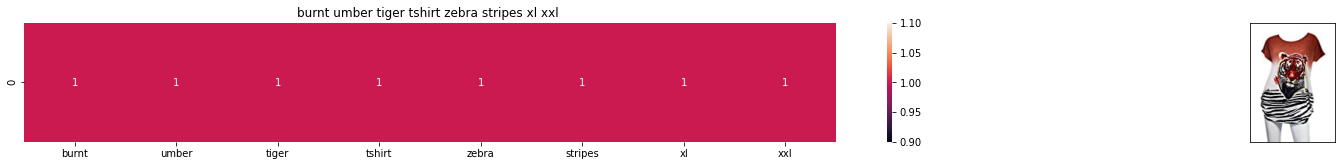

ASIN: B00JXQB5FQ
Brand: Si Row
Title: burnt umber tiger tshirt zebra stripes xl xxl 
Euclidean similarity with the query image : 0.0
************************************************************


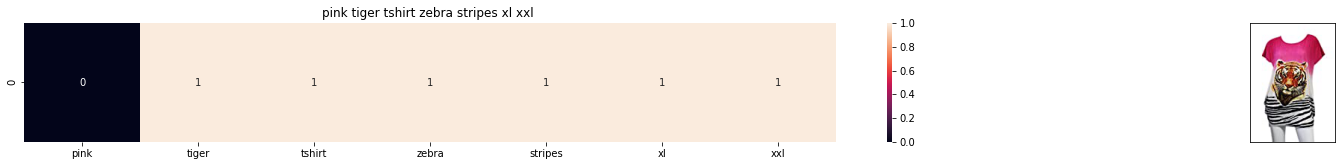

ASIN: B00JXQASS6
Brand: Si Row
Title: pink tiger tshirt zebra stripes xl xxl 
Euclidean similarity with the query image : 1.7320508075688772
************************************************************


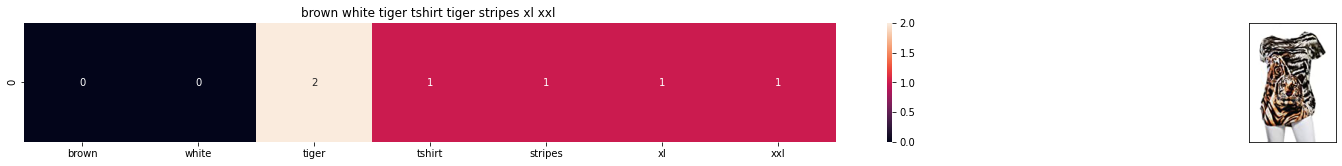

ASIN: B00JXQCWTO
Brand: Si Row
Title: brown white tiger tshirt tiger stripes xl xxl 
Euclidean similarity with the query image : 2.449489742783178
************************************************************


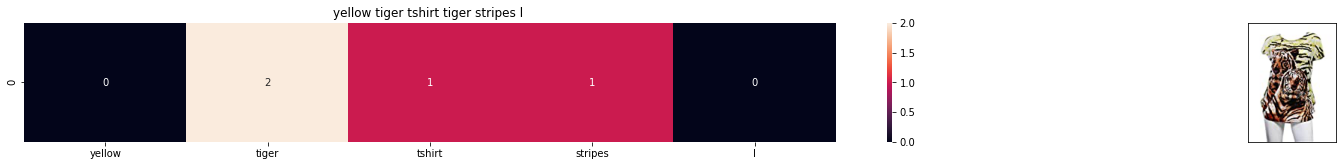

ASIN: B00JXQCUIC
Brand: Si Row
Title: yellow tiger tshirt tiger stripes l 
Euclidean similarity with the query image : 2.6457513110645907
************************************************************


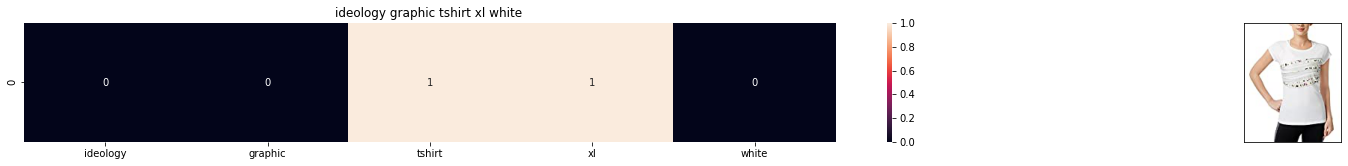

ASIN: B01NB0NKRO
Brand: Ideology
Title: ideology graphic tshirt xl white 
Euclidean similarity with the query image : 3.0
************************************************************


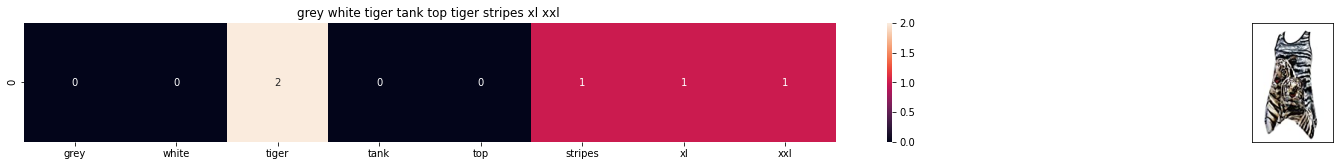

ASIN: B00JXQAFZ2
Brand: Si Row
Title: grey white tiger tank top tiger stripes xl xxl 
Euclidean similarity with the query image : 3.0
************************************************************


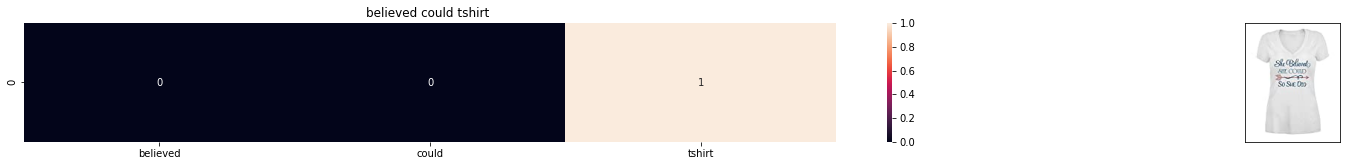

ASIN: B07568NZX4
Brand: Rustic Grace
Title: believed could tshirt 
Euclidean similarity with the query image : 3.0
************************************************************


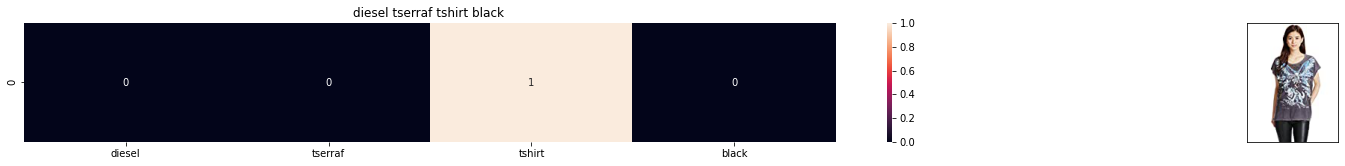

ASIN: B017X8PW9U
Brand: Diesel
Title: diesel tserraf tshirt black 
Euclidean similarity with the query image : 3.1622776601683795
************************************************************


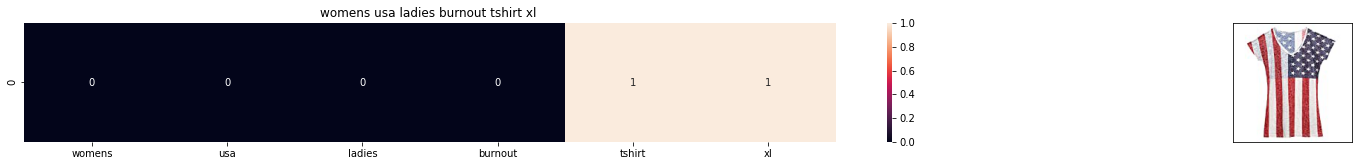

ASIN: B01F4D9CI8
Brand: Calhoun Sportswear
Title: womens usa ladies burnout tshirt xl 
Euclidean similarity with the query image : 3.1622776601683795
************************************************************


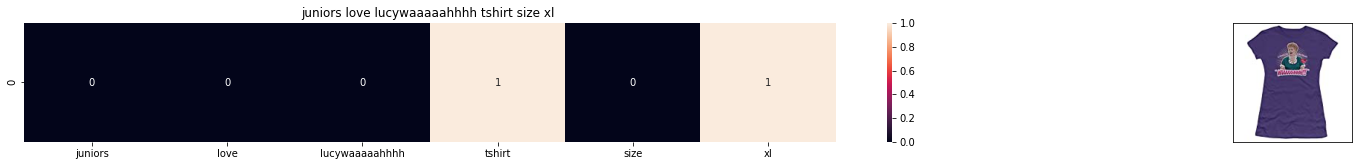

ASIN: B00IAA4JIQ
Brand: I Love Lucy
Title: juniors love lucywaaaaahhhh tshirt size xl 
Euclidean similarity with the query image : 3.1622776601683795
************************************************************


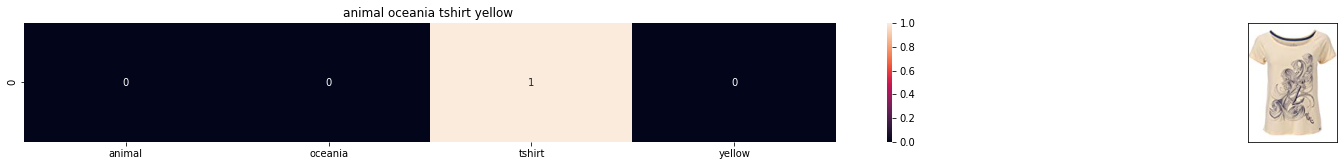

ASIN: B06X6GX6WG
Brand: Animal
Title: animal oceania tshirt yellow 
Euclidean similarity with the query image : 3.1622776601683795
************************************************************


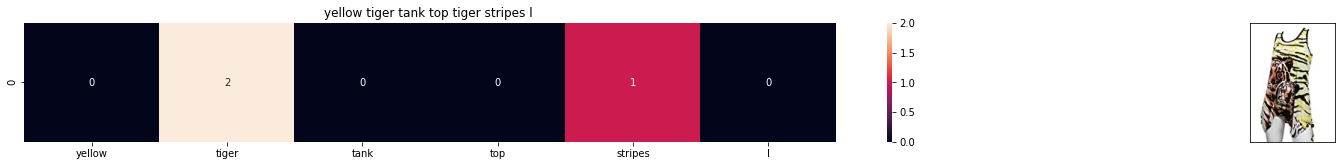

ASIN: B00JXQAUWA
Brand: Si Row
Title: yellow tiger tank top tiger stripes l 
Euclidean similarity with the query image : 3.1622776601683795
************************************************************


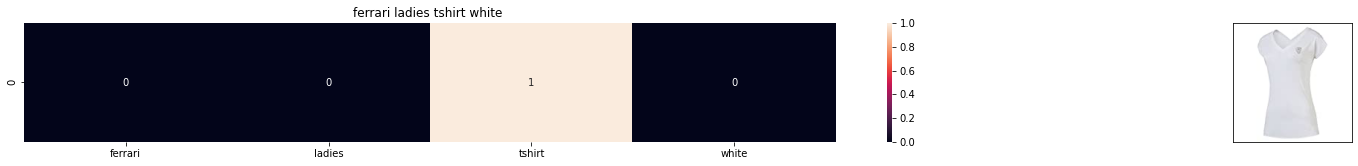

ASIN: B015YKMU80
Brand: PUMA
Title: ferrari ladies tshirt white 
Euclidean similarity with the query image : 3.1622776601683795
************************************************************


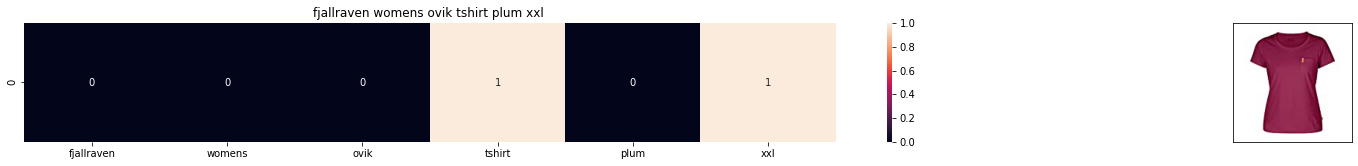

ASIN: B06XC3CZF6
Brand: Fjallraven
Title: fjallraven womens ovik tshirt plum xxl 
Euclidean similarity with the query image : 3.1622776601683795
************************************************************


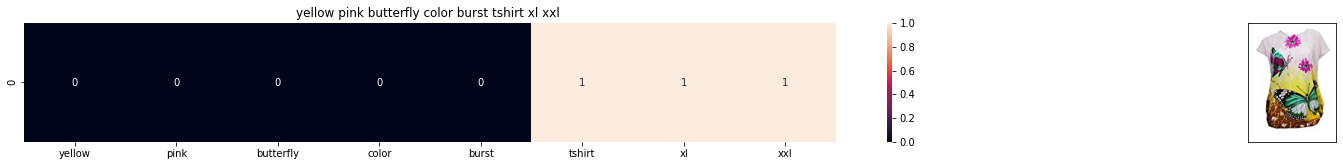

ASIN: B00JXQBBMI
Brand: Si Row
Title: yellow pink butterfly color burst tshirt xl xxl 
Euclidean similarity with the query image : 3.1622776601683795
************************************************************


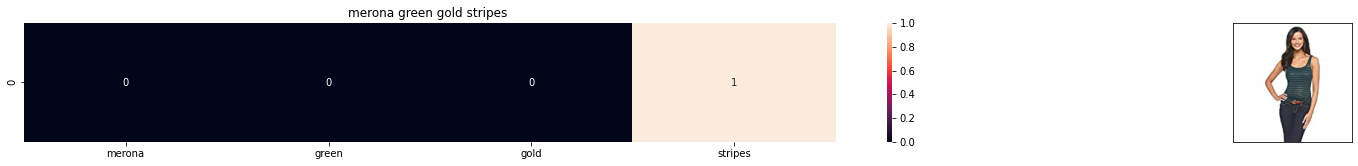

ASIN: B01KVZUB6G
Brand: Merona
Title: merona green gold stripes 
Euclidean similarity with the query image : 3.1622776601683795
************************************************************


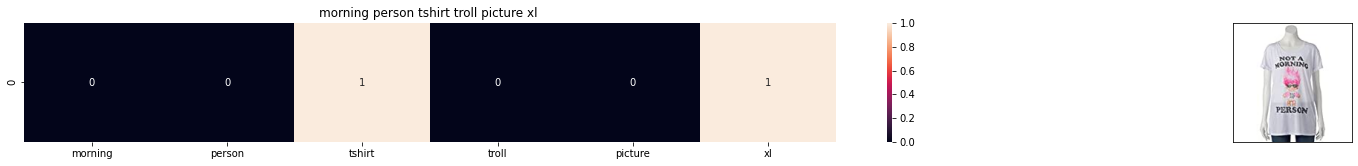

ASIN: B01CLS8LMW
Brand: Awake
Title: morning person tshirt troll picture xl 
Euclidean similarity with the query image : 3.1622776601683795
************************************************************


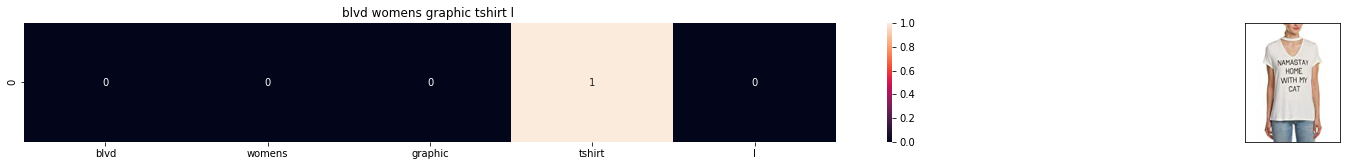

ASIN: B0733R2CJK
Brand: BLVD
Title: blvd womens graphic tshirt l 
Euclidean similarity with the query image : 3.1622776601683795
************************************************************


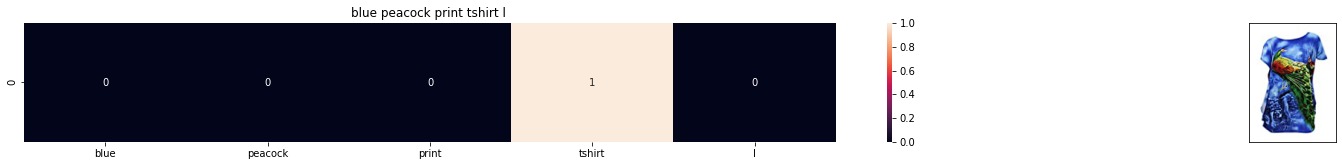

ASIN: B00JXQC8L6
Brand: Si Row
Title: blue peacock print tshirt l 
Euclidean similarity with the query image : 3.1622776601683795
************************************************************


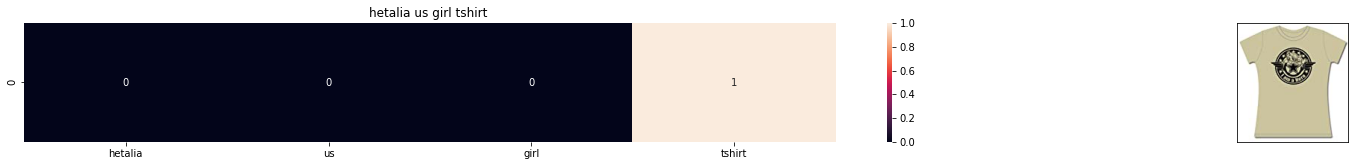

ASIN: B005IT8OBA
Brand: Hetalia
Title: hetalia us girl tshirt 
Euclidean similarity with the query image : 3.1622776601683795
************************************************************


In [118]:
bow_model(12920, 20)

## 2. TF-IDF

In [111]:
tf_idf_vectorizer = TfidfVectorizer(min_df = 0)
tf_idf_feature = tf_idf_vectorizer.fit_transform(data['title'])


In [112]:
def tfidf_model(doc_id, num_results):
    pair_wise_dist = pairwise_distances(tf_idf_feature, tf_idf_feature[doc_id])

    #indices of smalles distances
    indices = np.argsort(pair_wise_dist.flatten())[0:num_results]

    # smalles distances
    pdists = np.sort(pair_wise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])

    for i in range(0, len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')

        print('ASIN:', data['asin'].loc[df_indices[i]])
        print('Brand:', data['brand'].loc[df_indices[i]])
        print('Title:', data['title'].loc[df_indices[i]])
        print('Euclidean similarity with the query image :', pdists[i])
        print('*'*60)


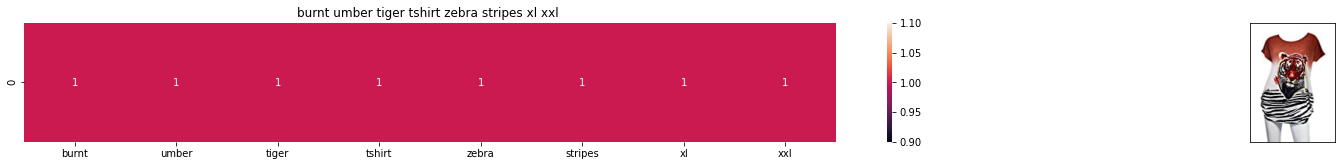

ASIN: B00JXQB5FQ
Brand: Si Row
Title: burnt umber tiger tshirt zebra stripes xl xxl 
Euclidean similarity with the query image : 0.0
************************************************************


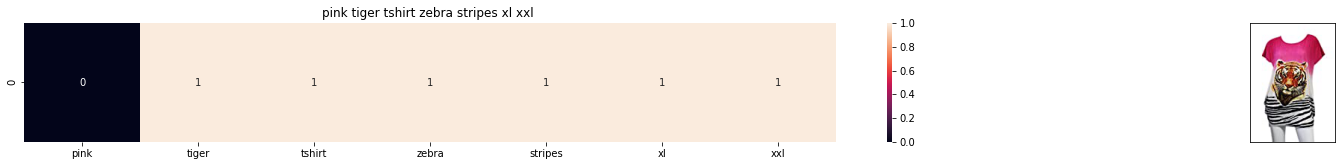

ASIN: B00JXQASS6
Brand: Si Row
Title: pink tiger tshirt zebra stripes xl xxl 
Euclidean similarity with the query image : 0.7533568922414481
************************************************************


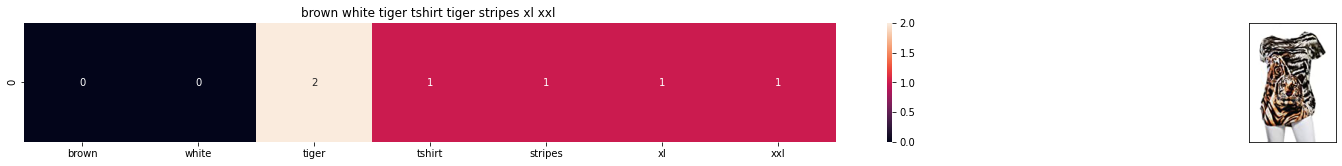

ASIN: B00JXQCWTO
Brand: Si Row
Title: brown white tiger tshirt tiger stripes xl xxl 
Euclidean similarity with the query image : 0.9358426776107838
************************************************************


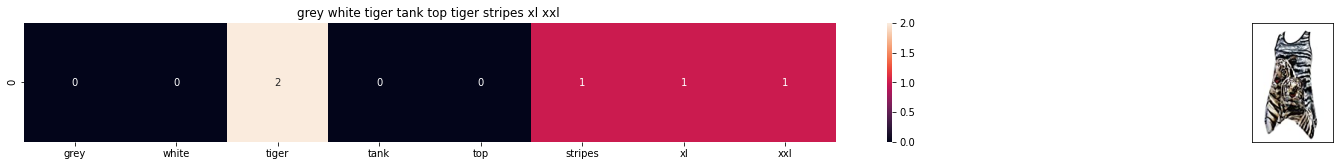

ASIN: B00JXQAFZ2
Brand: Si Row
Title: grey white tiger tank top tiger stripes xl xxl 
Euclidean similarity with the query image : 0.9582006587986819
************************************************************


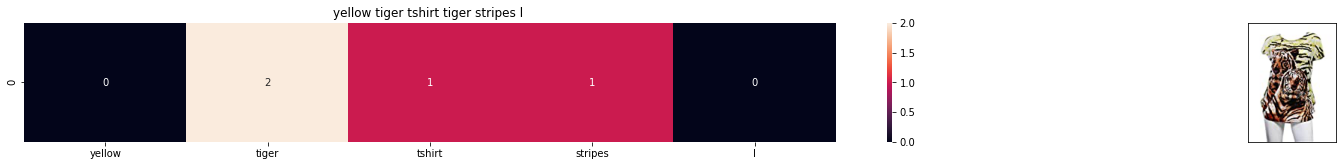

ASIN: B00JXQCUIC
Brand: Si Row
Title: yellow tiger tshirt tiger stripes l 
Euclidean similarity with the query image : 0.9996632570483577
************************************************************


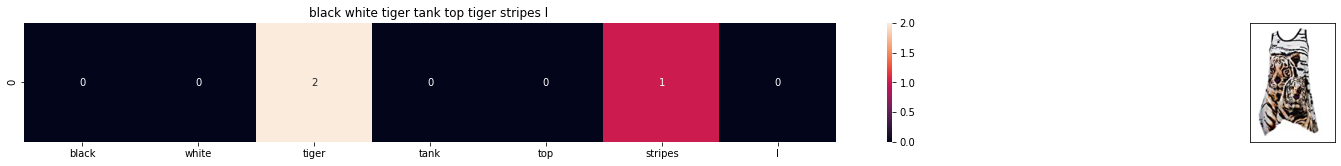

ASIN: B00JXQAO94
Brand: Si Row
Title: black white tiger tank top tiger stripes l 
Euclidean similarity with the query image : 1.0227541087867118
************************************************************


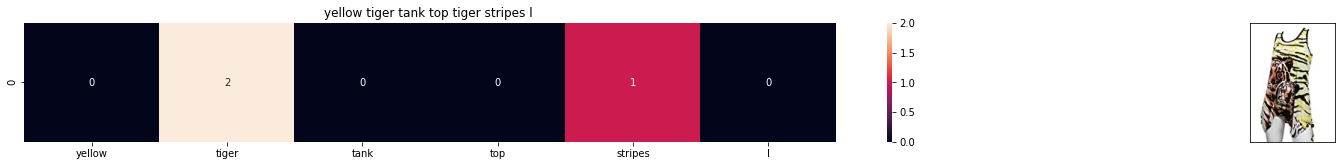

ASIN: B00JXQAUWA
Brand: Si Row
Title: yellow tiger tank top tiger stripes l 
Euclidean similarity with the query image : 1.031376316197352
************************************************************


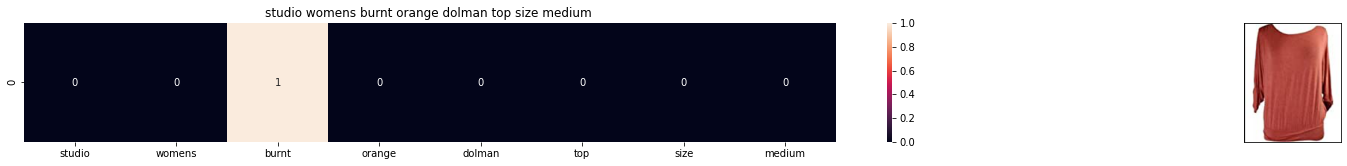

ASIN: B06XSCVFT5
Brand: Studio M
Title: studio womens burnt orange dolman top size medium 
Euclidean similarity with the query image : 1.2103514497160317
************************************************************


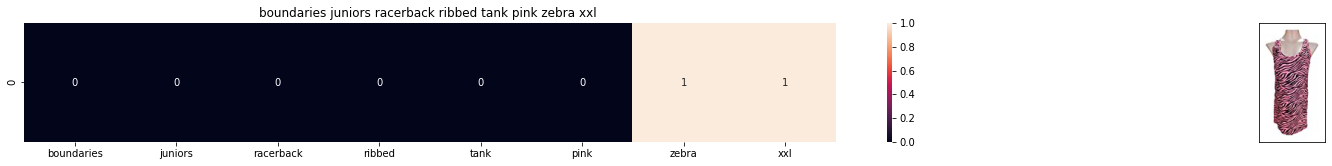

ASIN: B06Y2GTYPM
Brand: No Boundaries
Title: boundaries juniors racerback ribbed tank pink zebra xxl 
Euclidean similarity with the query image : 1.2118305793961062
************************************************************


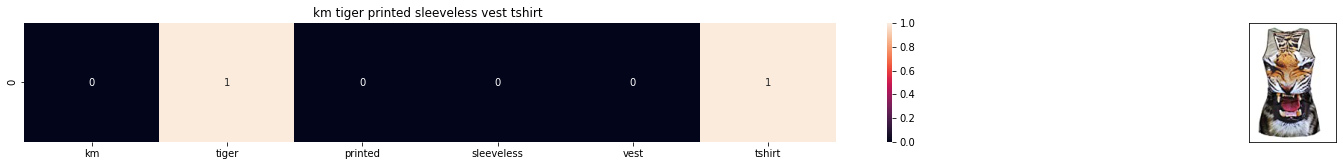

ASIN: B012VQLT6Y
Brand: KM T-shirt
Title: km tiger printed sleeveless vest tshirt 
Euclidean similarity with the query image : 1.2196267701012669
************************************************************


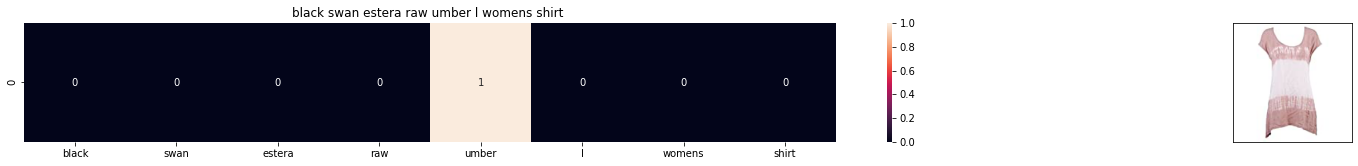

ASIN: B06Y1VN8WQ
Brand: Black Swan
Title: black swan estera raw umber l womens shirt 
Euclidean similarity with the query image : 1.2207177838856618
************************************************************


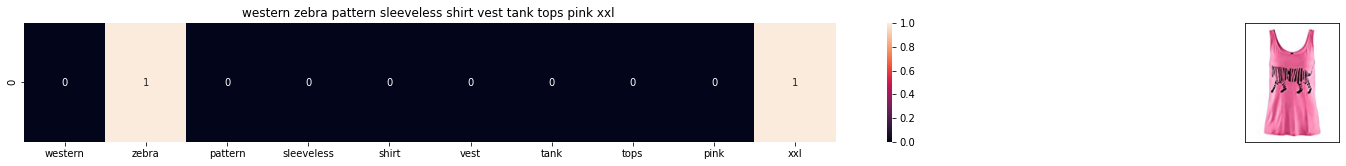

ASIN: B00Z6HEXWI
Brand: Black Temptation
Title: western zebra pattern sleeveless shirt vest tank tops pink xxl 
Euclidean similarity with the query image : 1.2210420821411552
************************************************************


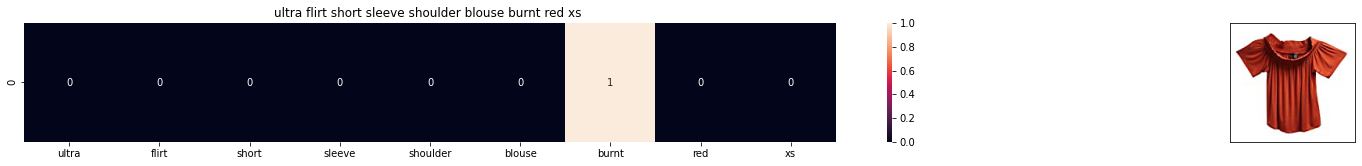

ASIN: B074TR12BH
Brand: Ultra Flirt
Title: ultra flirt short sleeve shoulder blouse burnt red xs 
Euclidean similarity with the query image : 1.2301296186992152
************************************************************


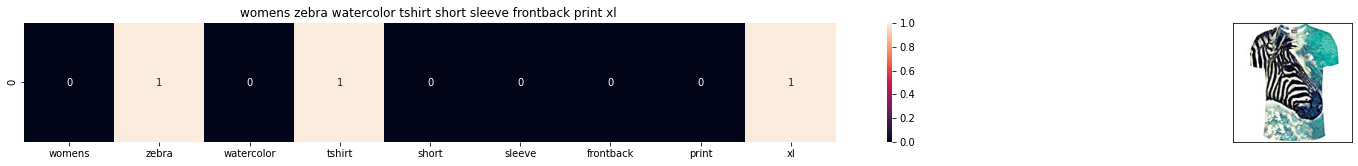

ASIN: B072R2JXKW
Brand: WHAT ON EARTH
Title: womens zebra watercolor tshirt short sleeve frontback print xl 
Euclidean similarity with the query image : 1.2318816625038385
************************************************************


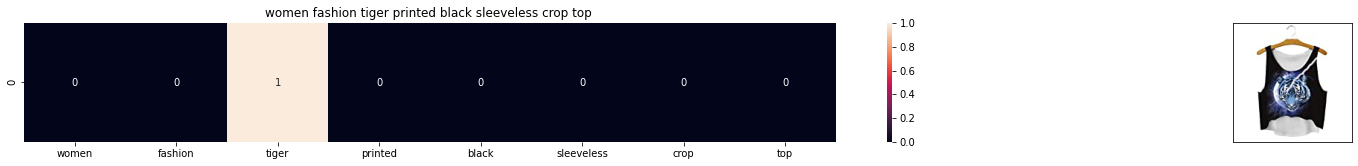

ASIN: B074T8ZYGX
Brand: MKP Crop Top
Title: women fashion tiger printed black sleeveless crop top 
Euclidean similarity with the query image : 1.2337530497226212
************************************************************


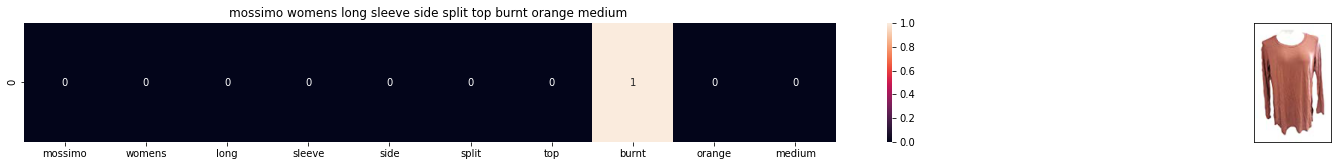

ASIN: B071ZDF6T2
Brand: Mossimo
Title: mossimo womens long sleeve side split top burnt orange medium 
Euclidean similarity with the query image : 1.2350653691405404
************************************************************


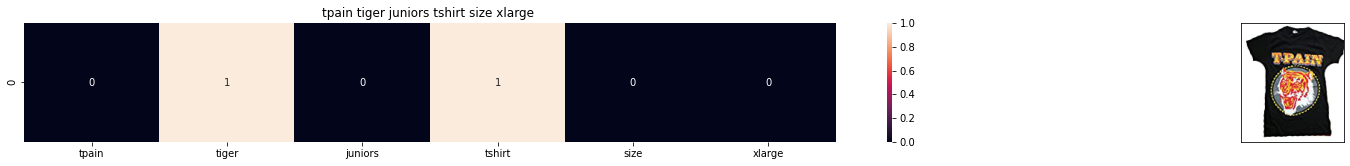

ASIN: B01K0H02OG
Brand: Tultex
Title: tpain tiger juniors tshirt size xlarge 
Euclidean similarity with the query image : 1.2363932943011302
************************************************************


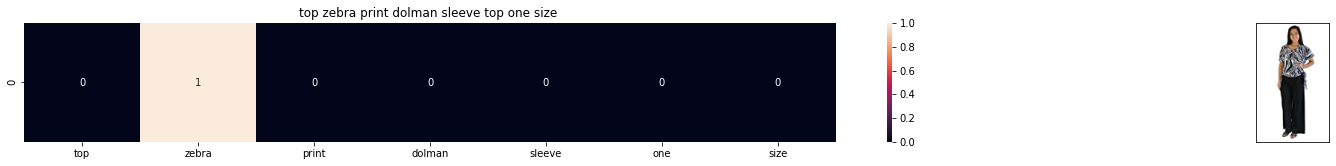

ASIN: B00H8A6ZLI
Brand: Vivian's Fashions
Title: top zebra print dolman sleeve top one size 
Euclidean similarity with the query image : 1.2494624816865354
************************************************************


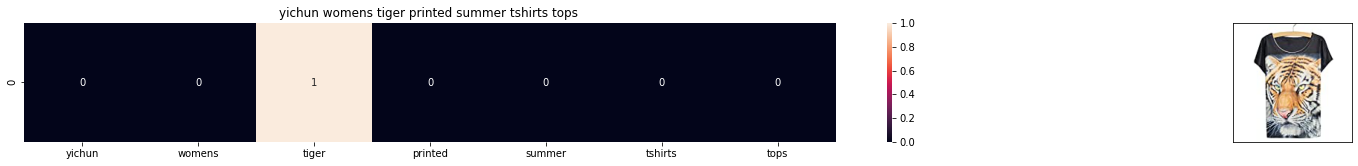

ASIN: B010NN9RXO
Brand: YICHUN
Title: yichun womens tiger printed summer tshirts tops 
Euclidean similarity with the query image : 1.2529812121128832
************************************************************


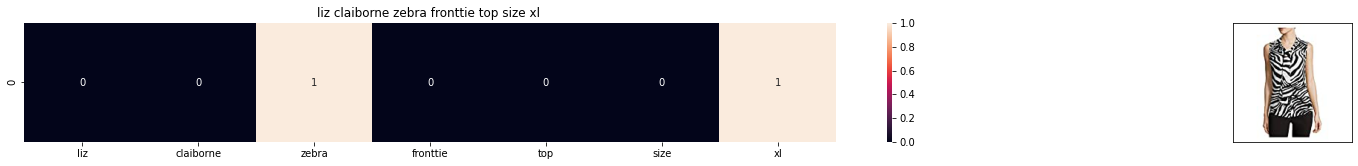

ASIN: B06XBY5QXL
Brand: Liz Claiborne
Title: liz claiborne zebra fronttie top size xl 
Euclidean similarity with the query image : 1.2534974207784417
************************************************************


In [117]:
tfidf_model(12920,20)

## 3.Weighted Word2Vec or Text semantic based

In [119]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))




In [120]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
        

In [122]:
def get_word_vec(sentence, doc_id , m_name):
    #sentence = title, doc_id = id
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            vec.append(np,zeros(shape = (300,)))
    return np.array(vec)

In [123]:
def get_distance(vec1, vec2):
    final_dist = []
    
    # for each vector in vec1 we calculate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
        
    return np.array(final_dist)
        

In [124]:
def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [127]:
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [128]:
vocab = model.keys()

# this function witll add the vectors fo each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [129]:
doc_id = 0
w2v_title = []
# for every title we build a avg vector representation
for i in data['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title = np.array(w2v_title)


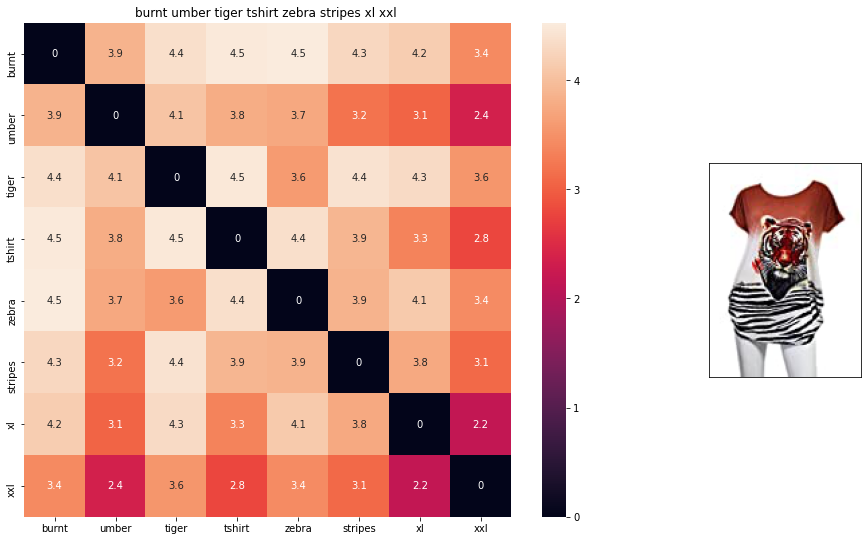

ASIN : B00JXQB5FQ
BRAND : Si Row
euclidean distance from given input image : 0.0
*****************************************************************************************************************************


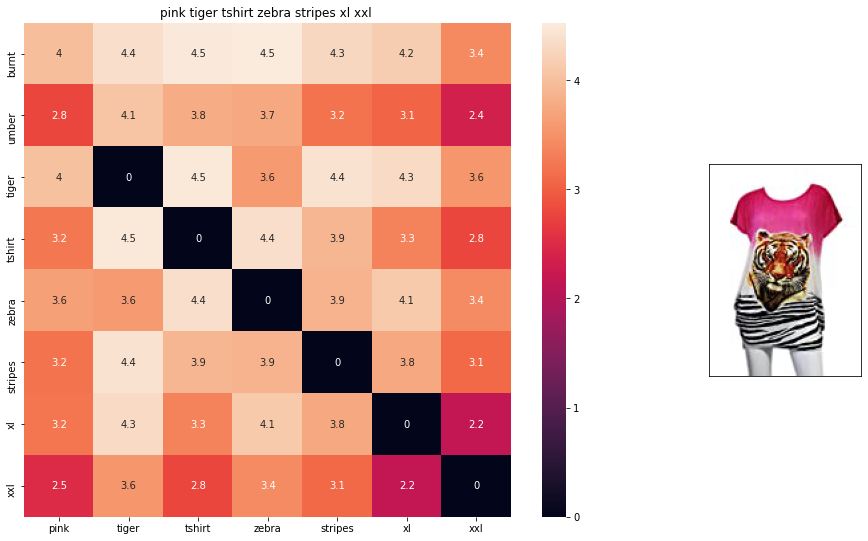

ASIN : B00JXQASS6
BRAND : Si Row
euclidean distance from given input image : 0.5891926
*****************************************************************************************************************************


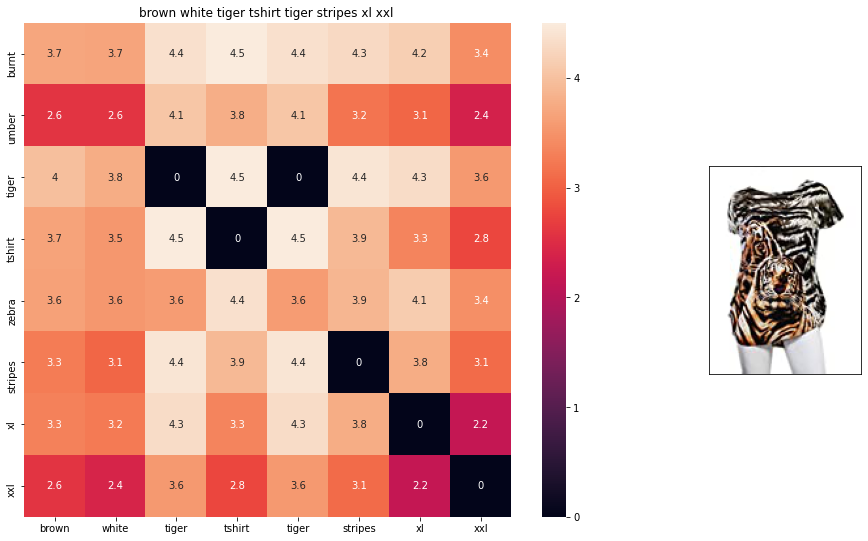

ASIN : B00JXQCWTO
BRAND : Si Row
euclidean distance from given input image : 0.7003438
*****************************************************************************************************************************


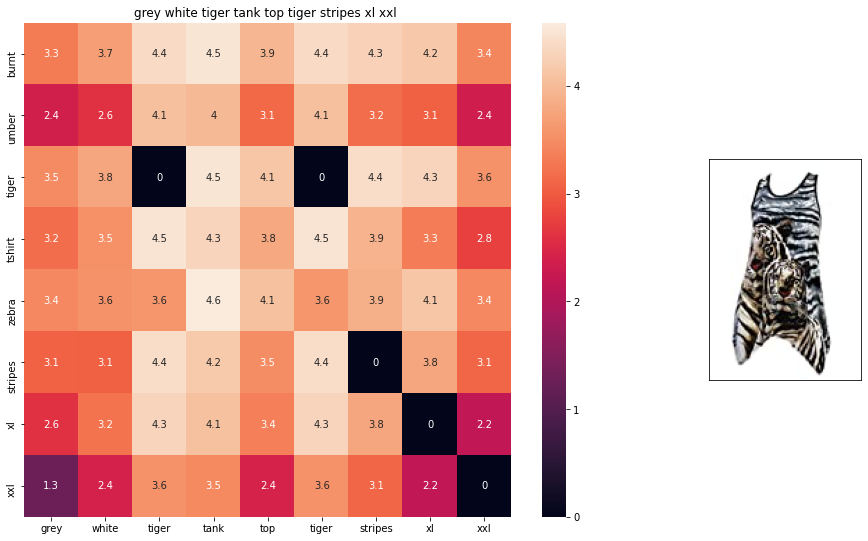

ASIN : B00JXQAFZ2
BRAND : Si Row
euclidean distance from given input image : 0.89283955
*****************************************************************************************************************************


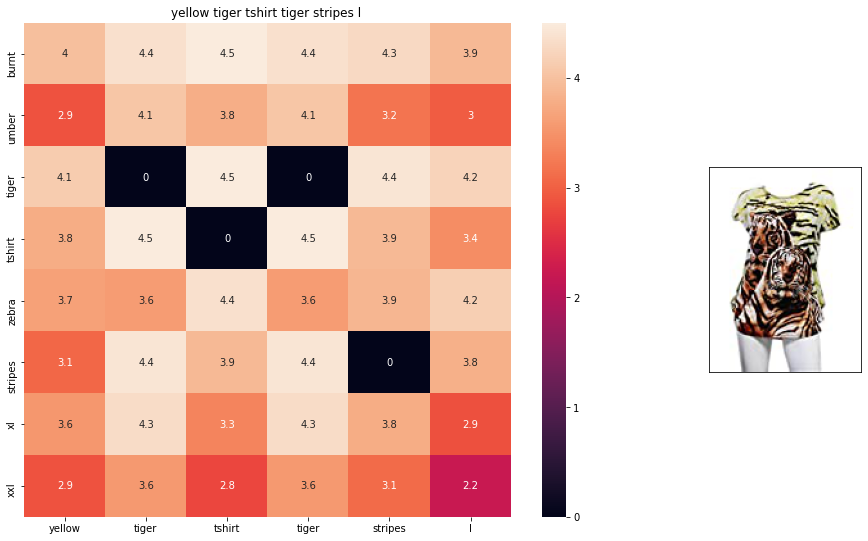

ASIN : B00JXQCUIC
BRAND : Si Row
euclidean distance from given input image : 0.95601255
*****************************************************************************************************************************


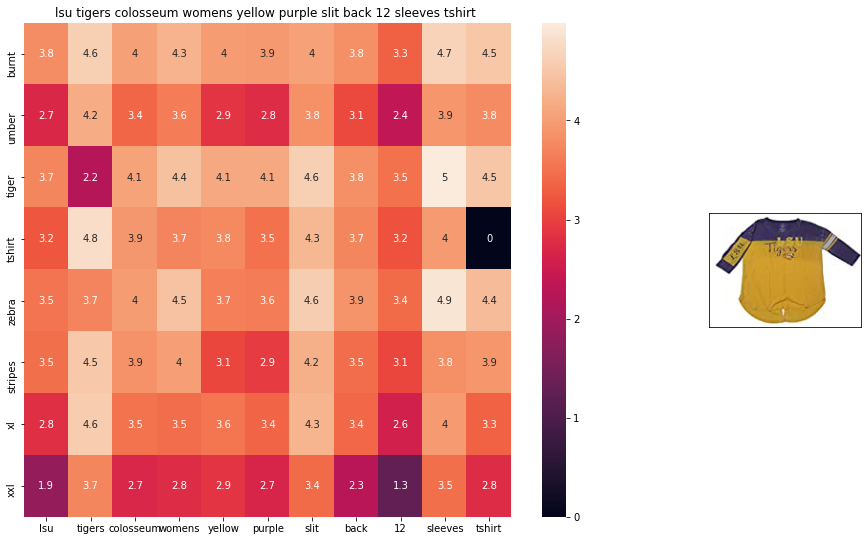

ASIN : B073R5Q8HD
BRAND : Colosseum
euclidean distance from given input image : 1.022969
*****************************************************************************************************************************


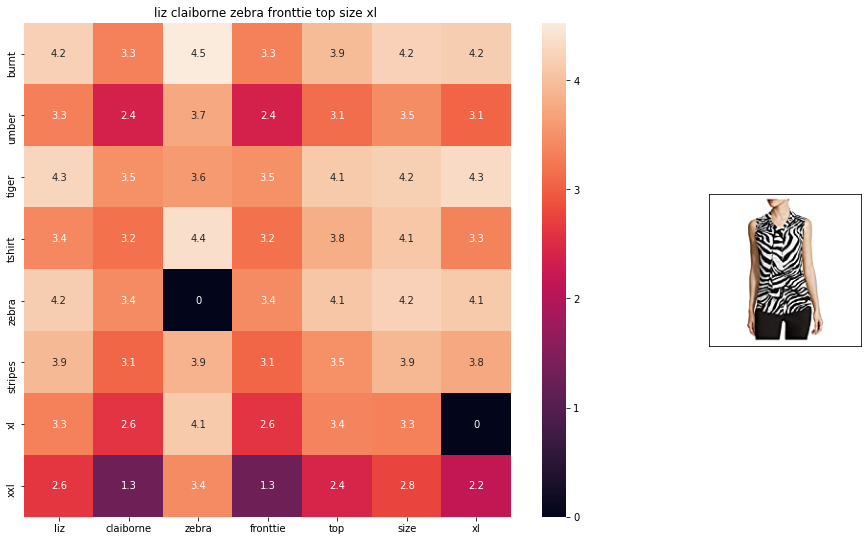

ASIN : B06XBY5QXL
BRAND : Liz Claiborne
euclidean distance from given input image : 1.0669324
*****************************************************************************************************************************


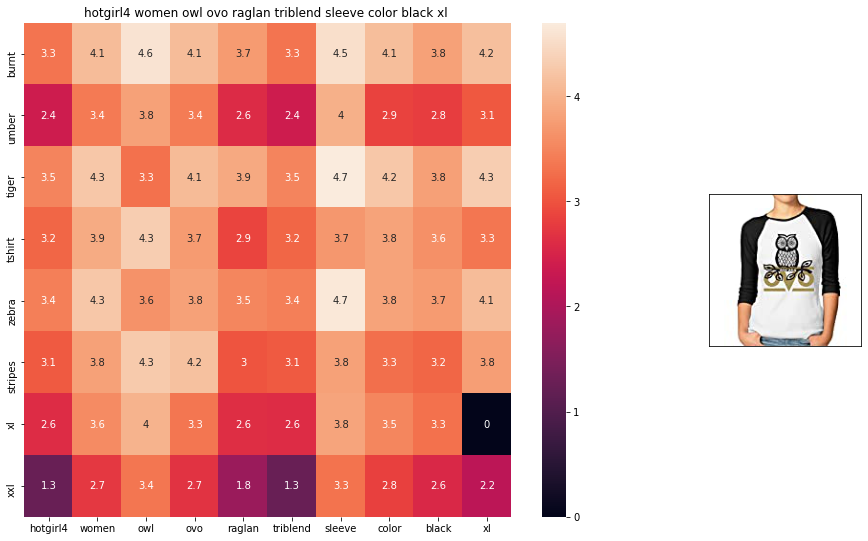

ASIN : B01L8L73M2
BRAND : Hotgirl4 Raglan Design
euclidean distance from given input image : 1.0731405
*****************************************************************************************************************************


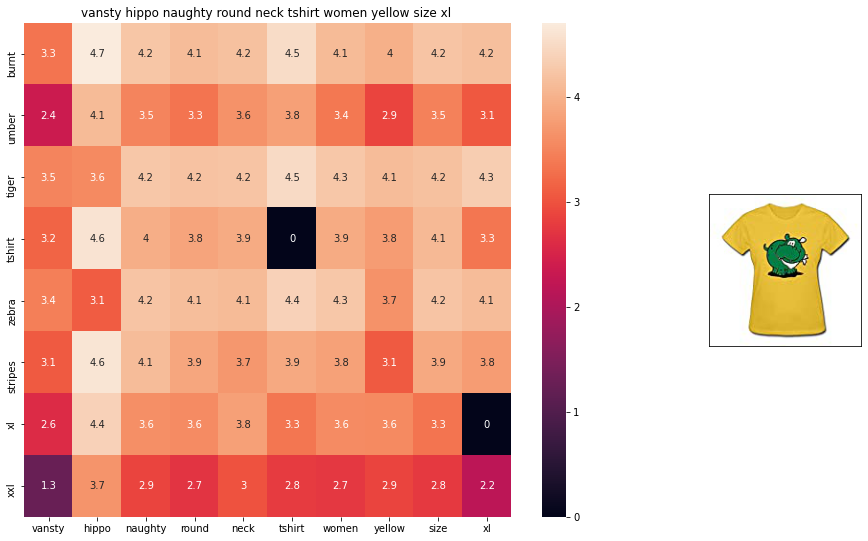

ASIN : B01EJS5H06
BRAND : Vansty
euclidean distance from given input image : 1.075719
*****************************************************************************************************************************


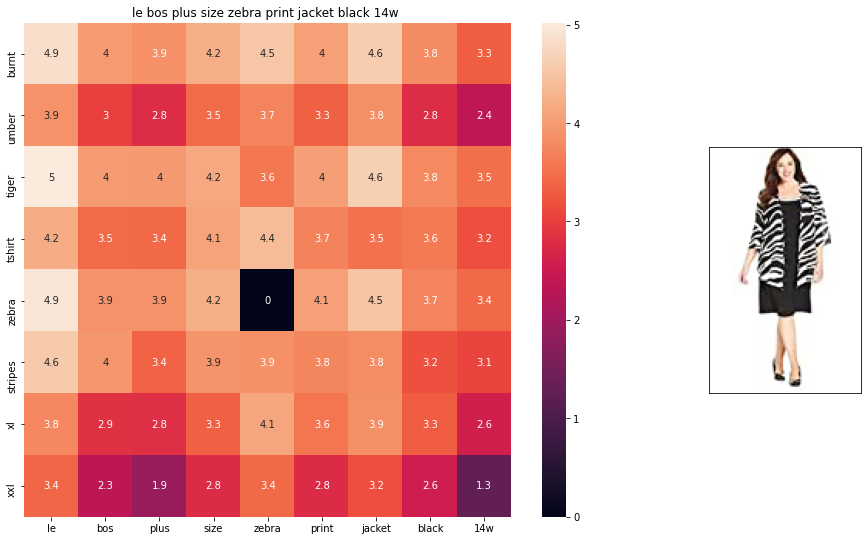

ASIN : B01BO1XRK8
BRAND : Le Bos
euclidean distance from given input image : 1.0839964
*****************************************************************************************************************************


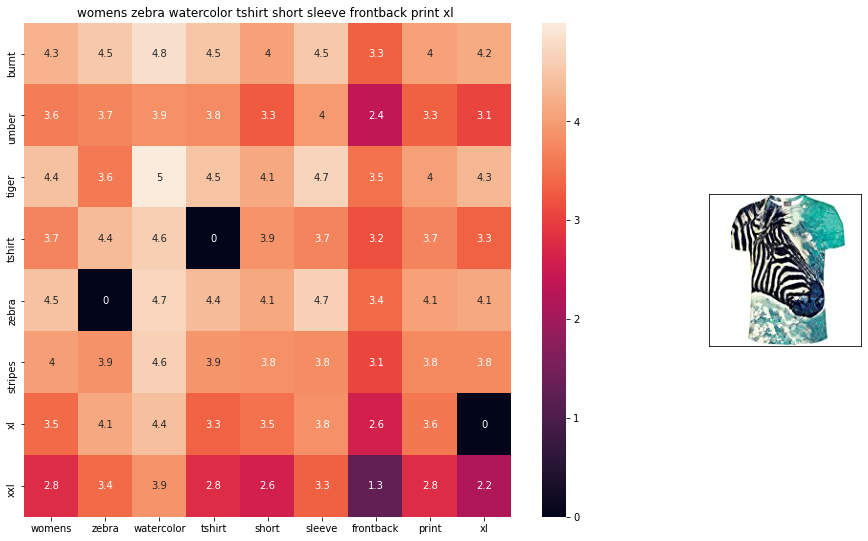

ASIN : B072R2JXKW
BRAND : WHAT ON EARTH
euclidean distance from given input image : 1.0842218
*****************************************************************************************************************************


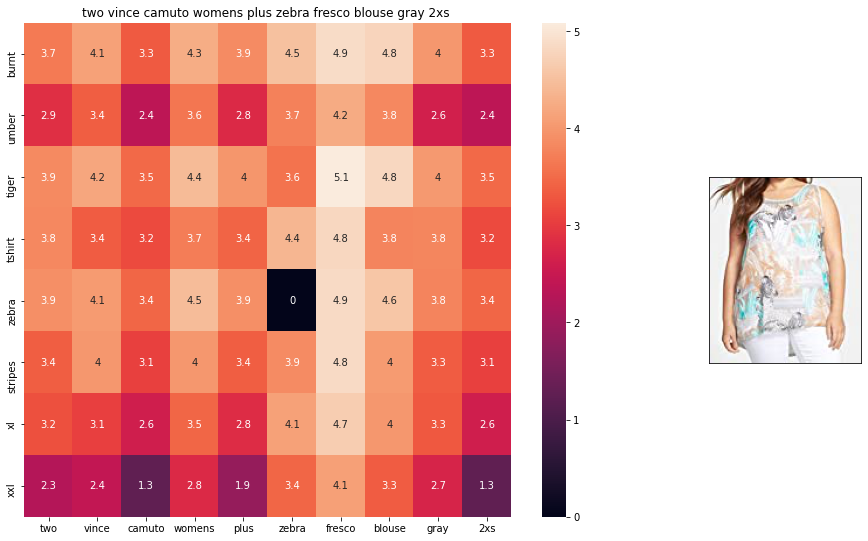

ASIN : B074MJRGW6
BRAND : Two by Vince Camuto
euclidean distance from given input image : 1.0895038
*****************************************************************************************************************************


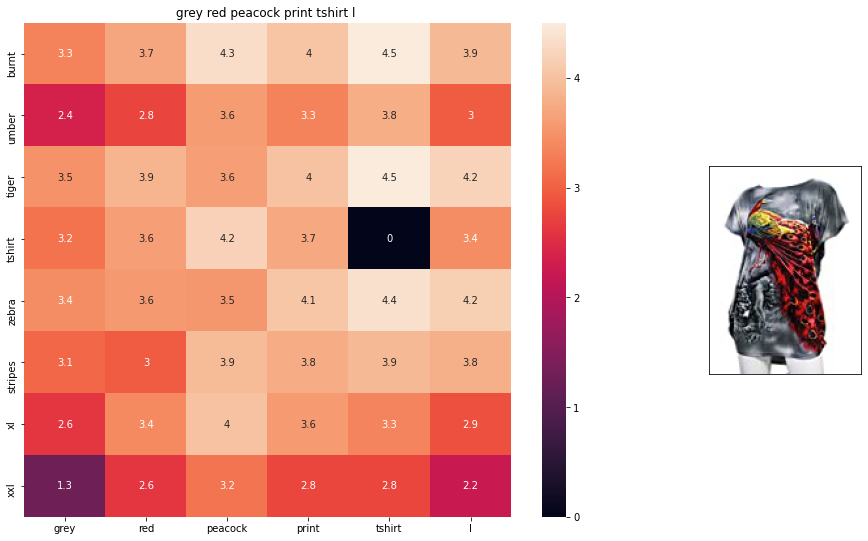

ASIN : B00JXQCFRS
BRAND : Si Row
euclidean distance from given input image : 1.0900588
*****************************************************************************************************************************


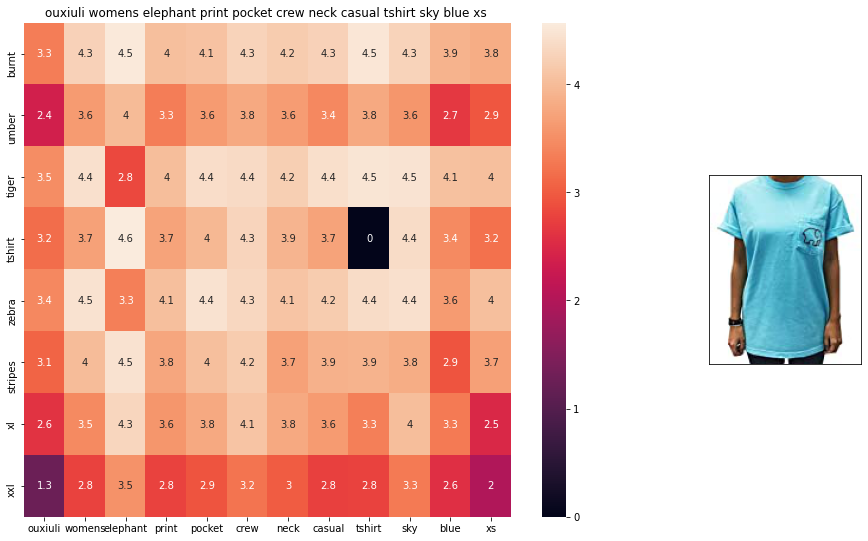

ASIN : B01I53HU6K
BRAND : ouxiuli
euclidean distance from given input image : 1.0920111
*****************************************************************************************************************************


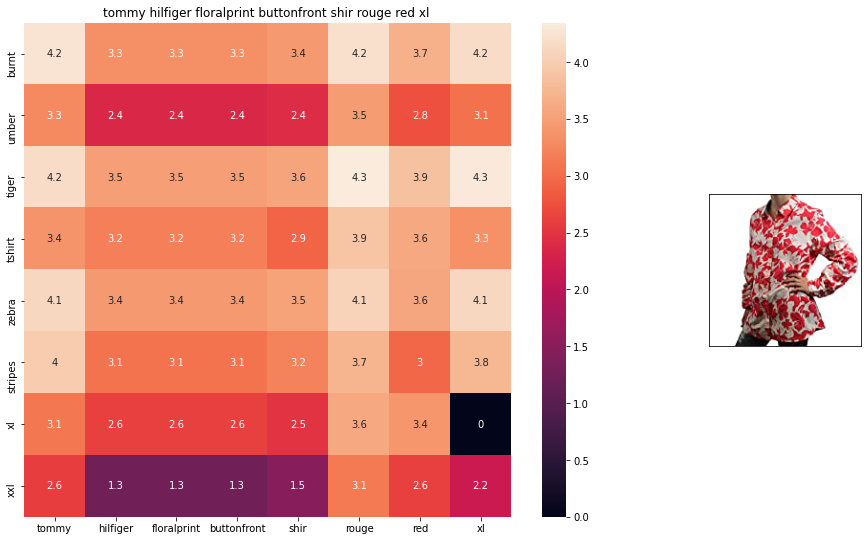

ASIN : B0711NGTQM
BRAND : THILFIGER RTW
euclidean distance from given input image : 1.0923415
*****************************************************************************************************************************


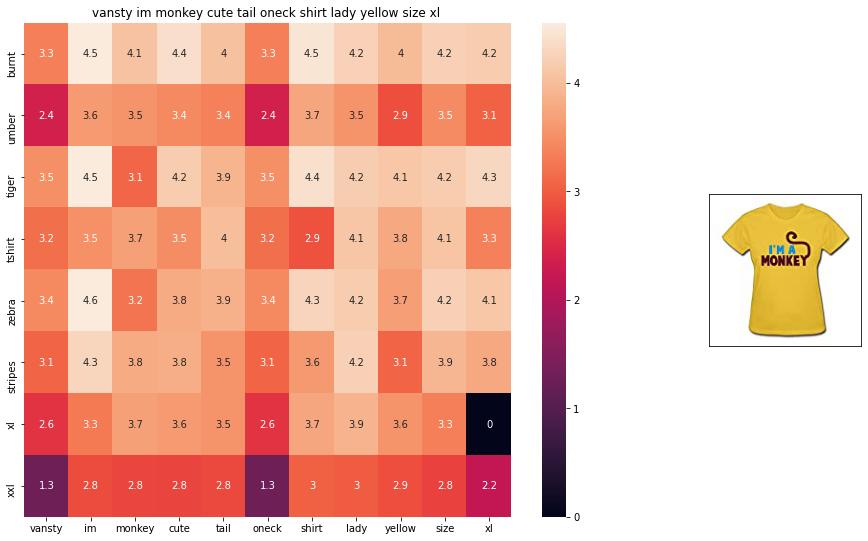

ASIN : B01EFSLO8Y
BRAND : Vansty
euclidean distance from given input image : 1.0934004
*****************************************************************************************************************************


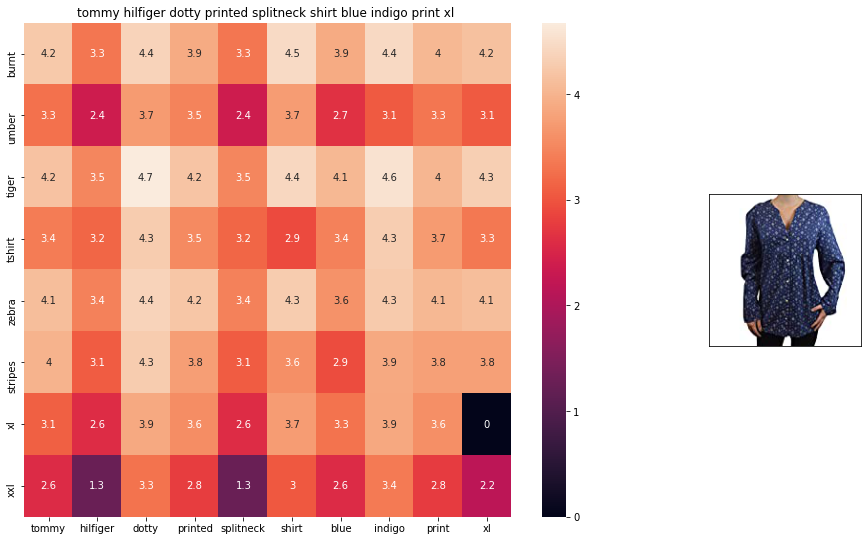

ASIN : B0716TVWQ4
BRAND : THILFIGER RTW
euclidean distance from given input image : 1.0942024
*****************************************************************************************************************************


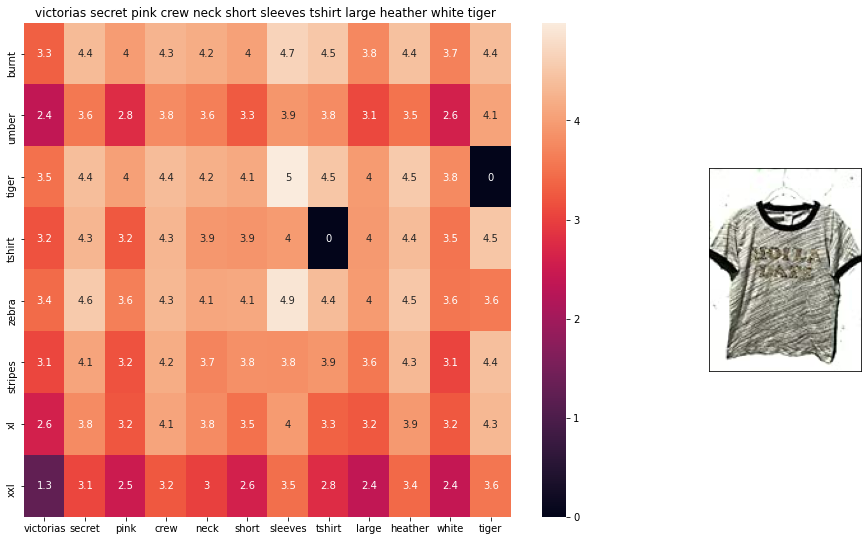

ASIN : B0716MVPGV
BRAND : V.Secret
euclidean distance from given input image : 1.0948304
*****************************************************************************************************************************


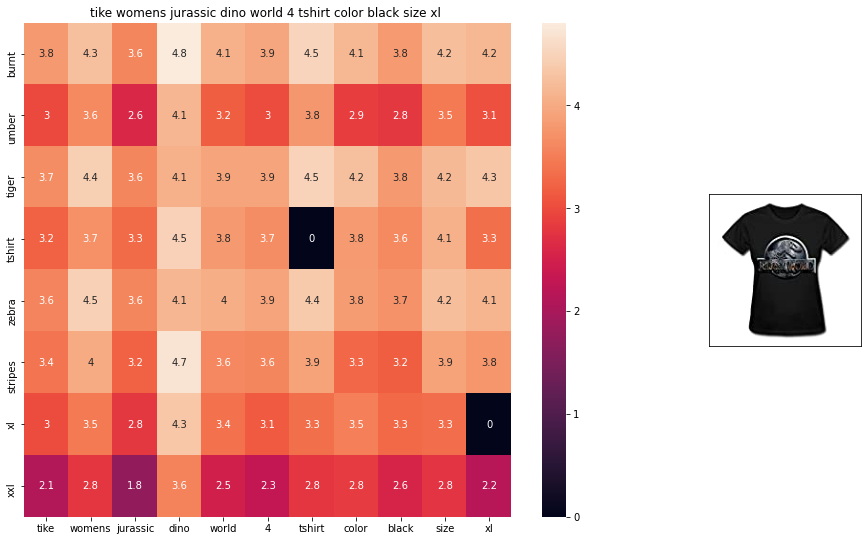

ASIN : B016OPN4OI
BRAND : TIKE Fashions
euclidean distance from given input image : 1.0951275
*****************************************************************************************************************************


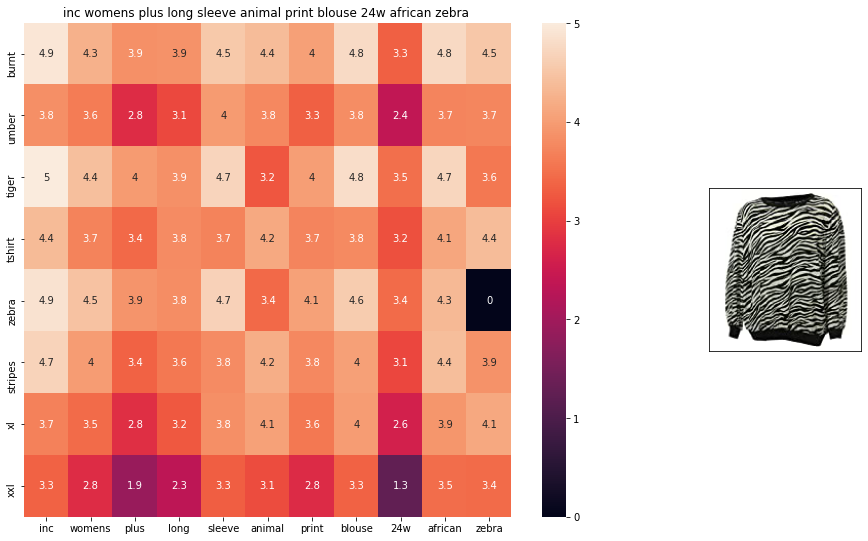

ASIN : B018WDJCUA
BRAND : INC - International Concepts Woman
euclidean distance from given input image : 1.0966892
*****************************************************************************************************************************


In [132]:
def avg_w2v_model(doc_id, num_results):

    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from given input image :', pdists[i])
        print('*'*125)

        
avg_w2v_model(12920, 20)


## 4. IDF weighted Word2Vec

In [133]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

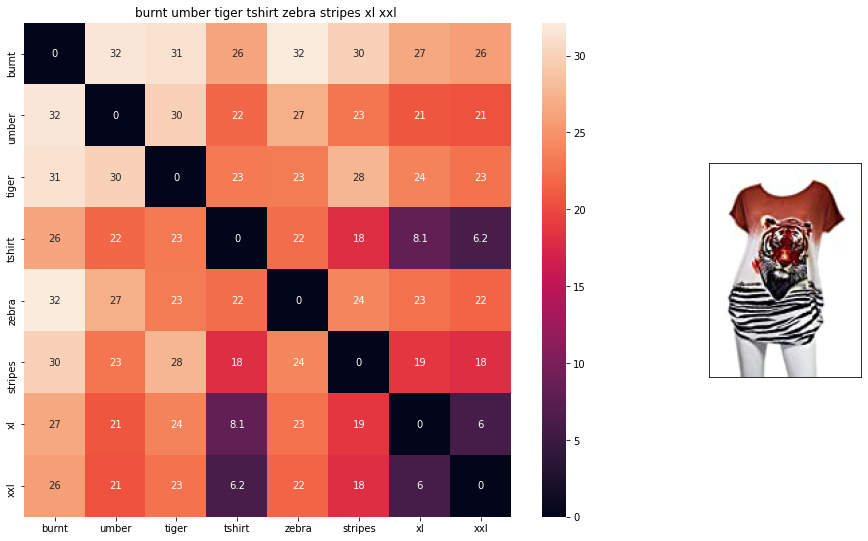

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.0


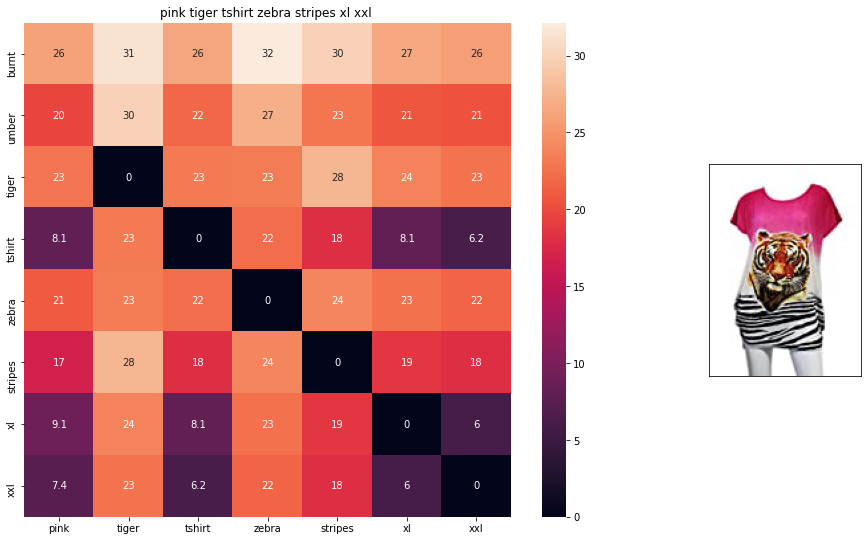

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 4.075806


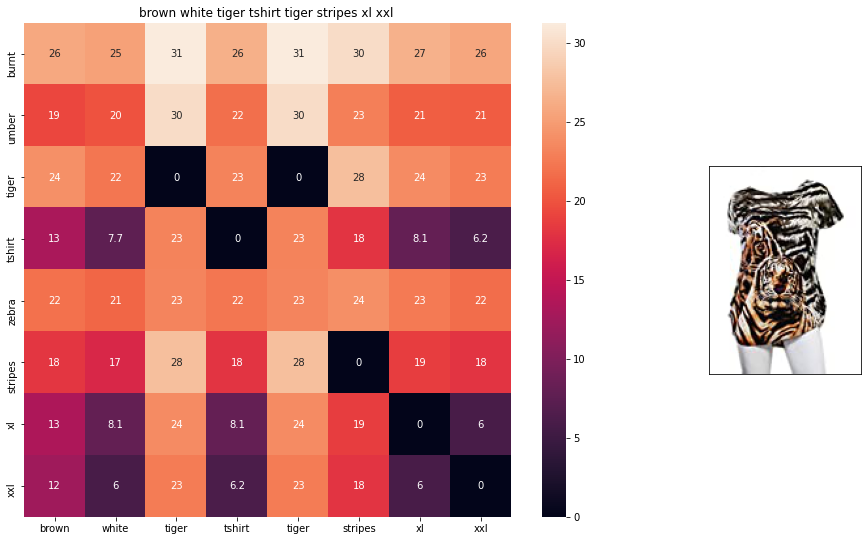

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 4.7862825


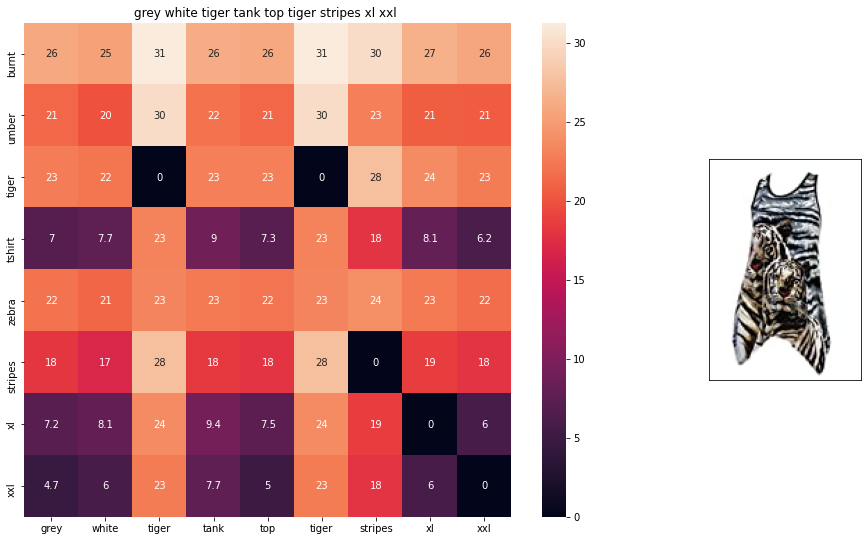

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from input : 5.3759933


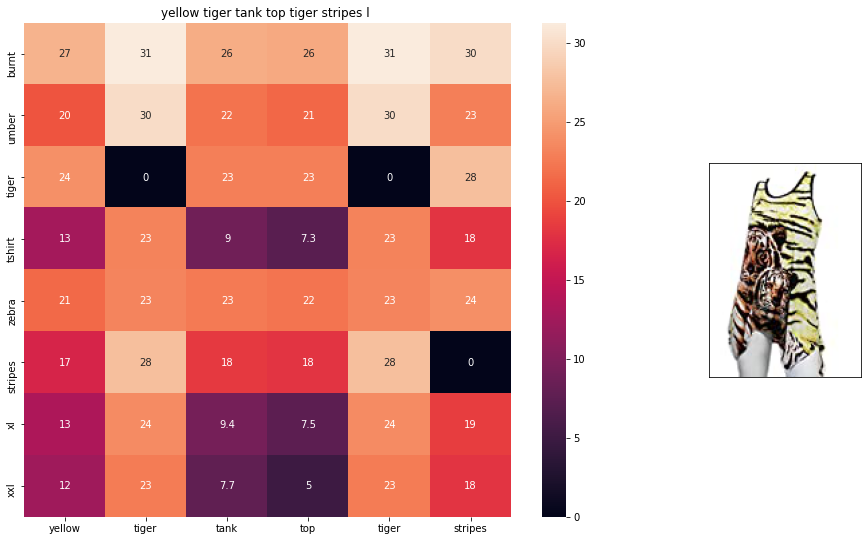

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from input : 5.705563


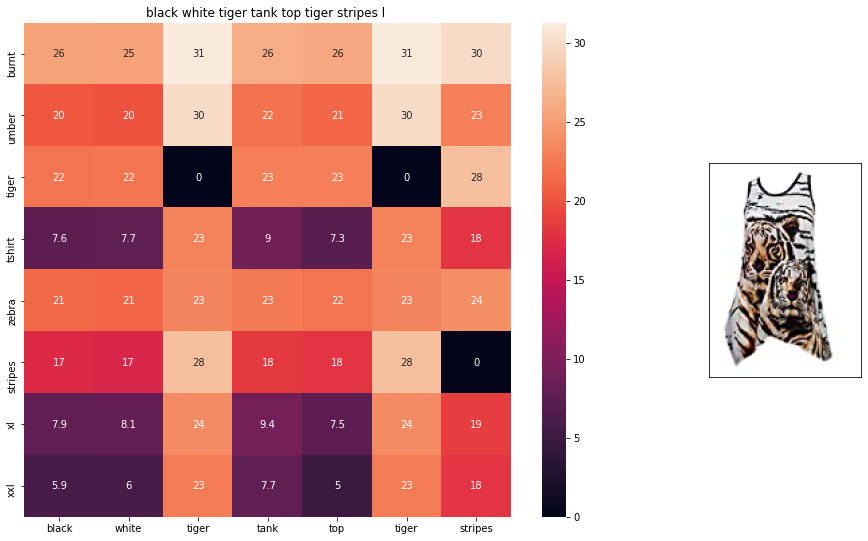

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from input : 5.7086053


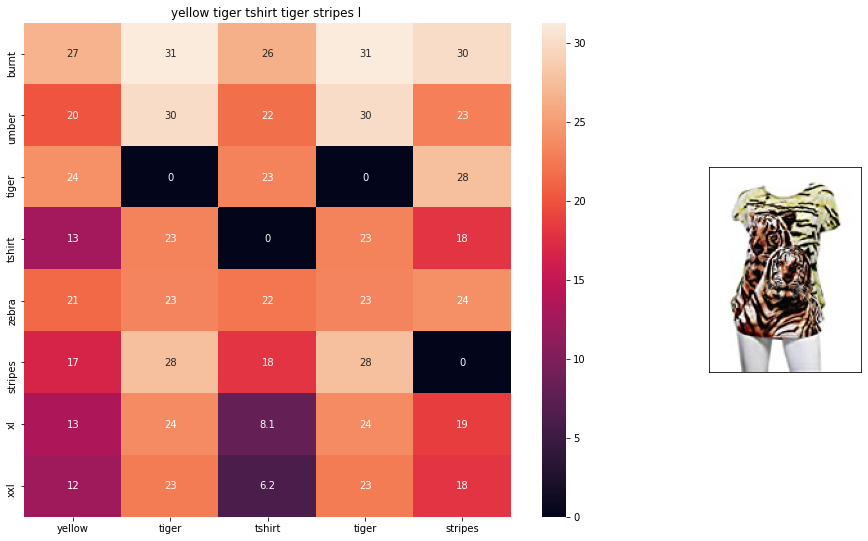

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from input : 5.911221


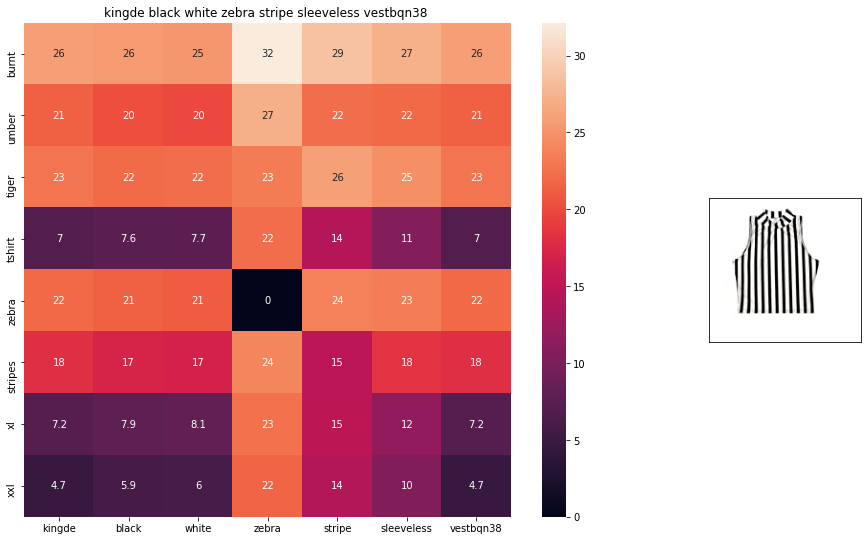

ASIN : B015H41F6G
Brand : KINGDE
euclidean distance from input : 6.151347


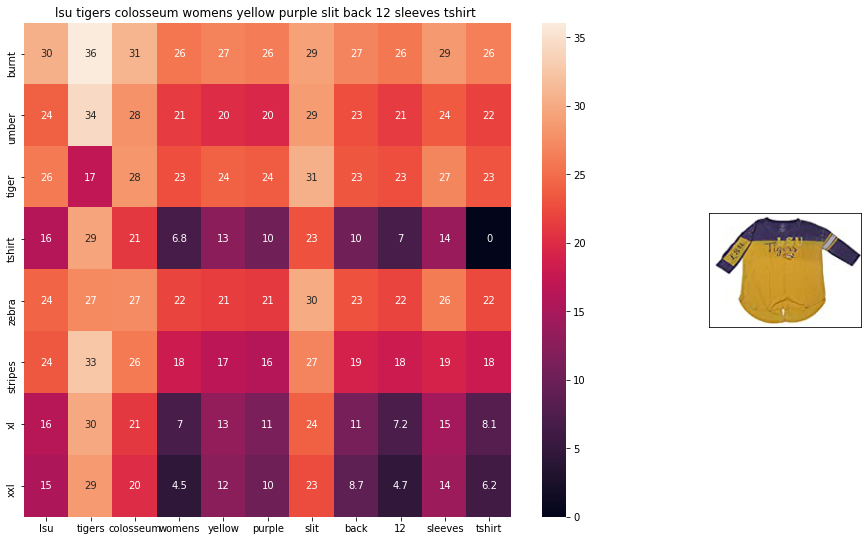

ASIN : B073R5Q8HD
Brand : Colosseum
euclidean distance from input : 6.278397


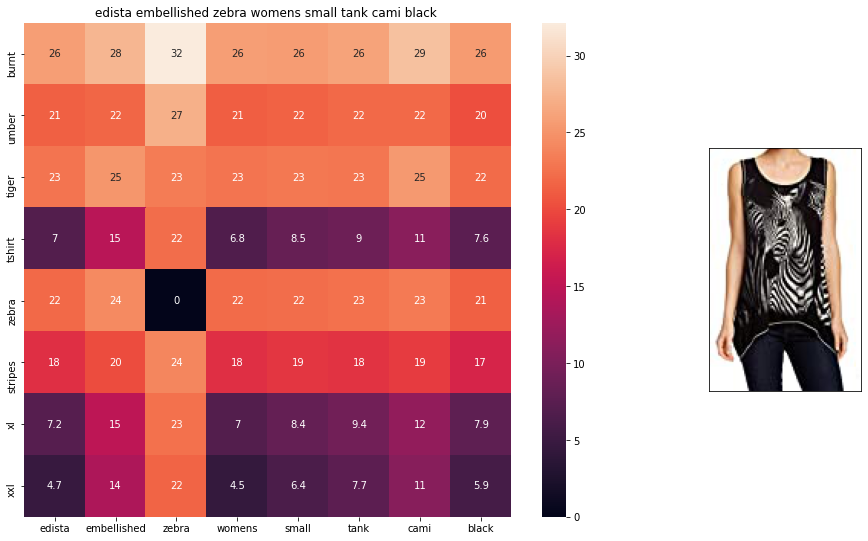

ASIN : B074P8MD22
Brand : Edista
euclidean distance from input : 6.4121304


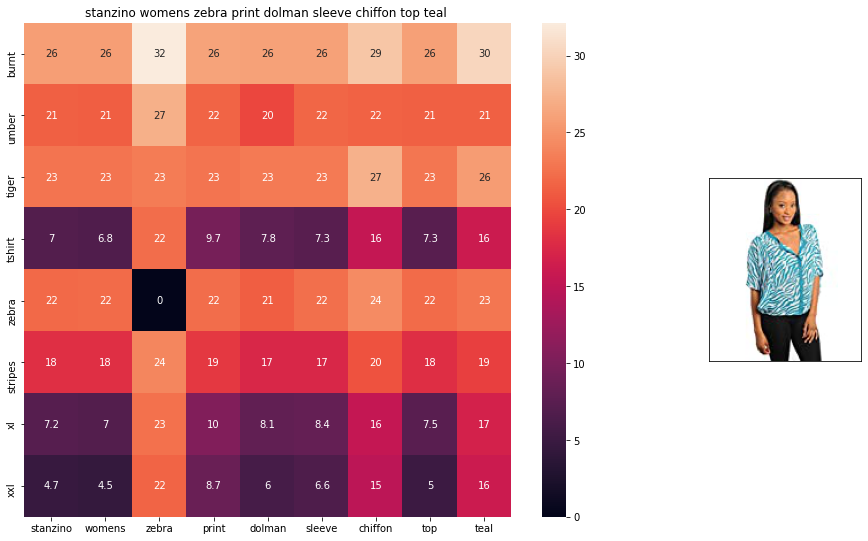

ASIN : B00C0I3U3E
Brand : Stanzino
euclidean distance from input : 6.434626


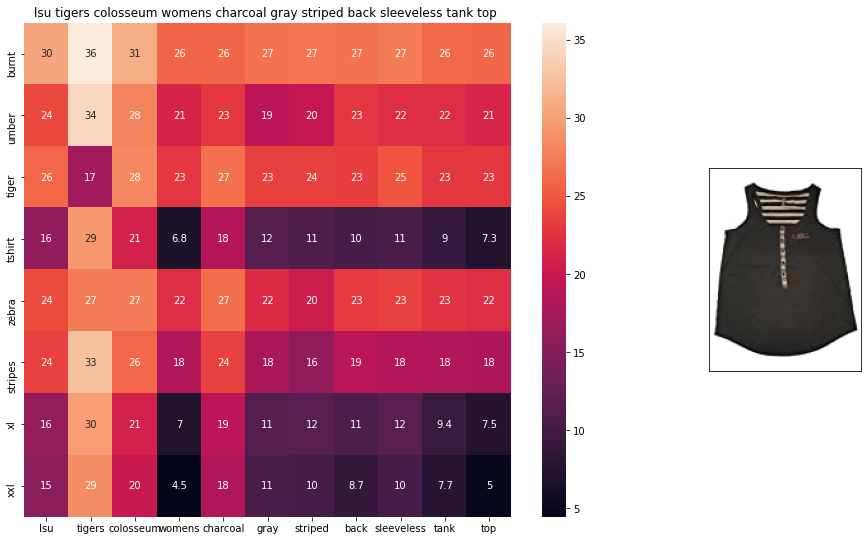

ASIN : B073R4ZM7Y
Brand : Colosseum
euclidean distance from input : 6.470668


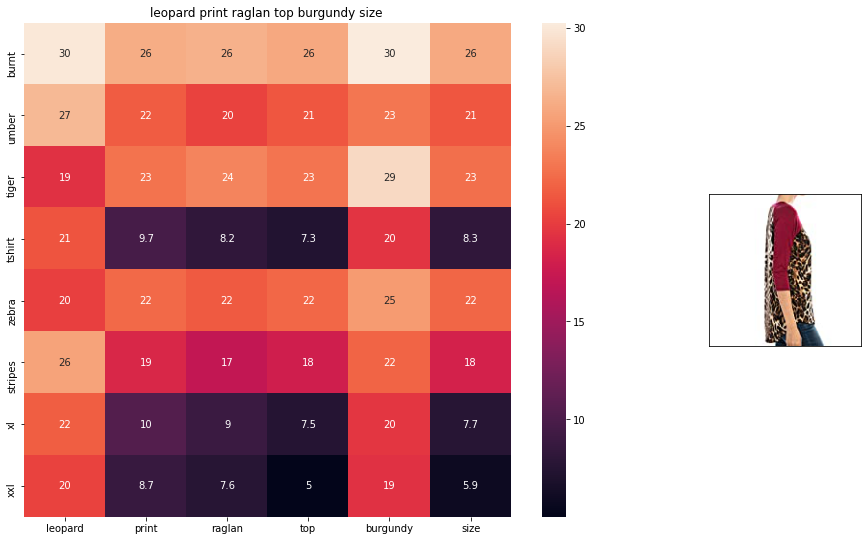

ASIN : B01C6ORLDQ
Brand : 1 Mad Fit
euclidean distance from input : 6.484849


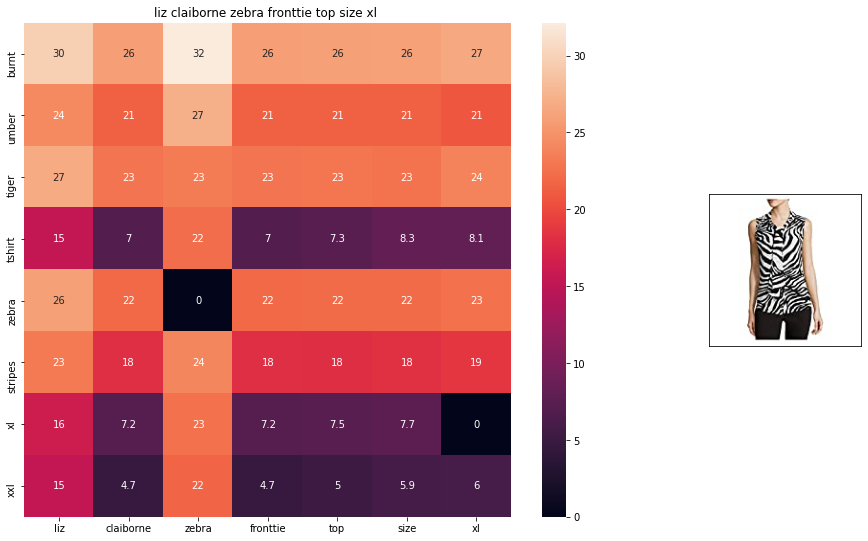

ASIN : B06XBY5QXL
Brand : Liz Claiborne
euclidean distance from input : 6.55883


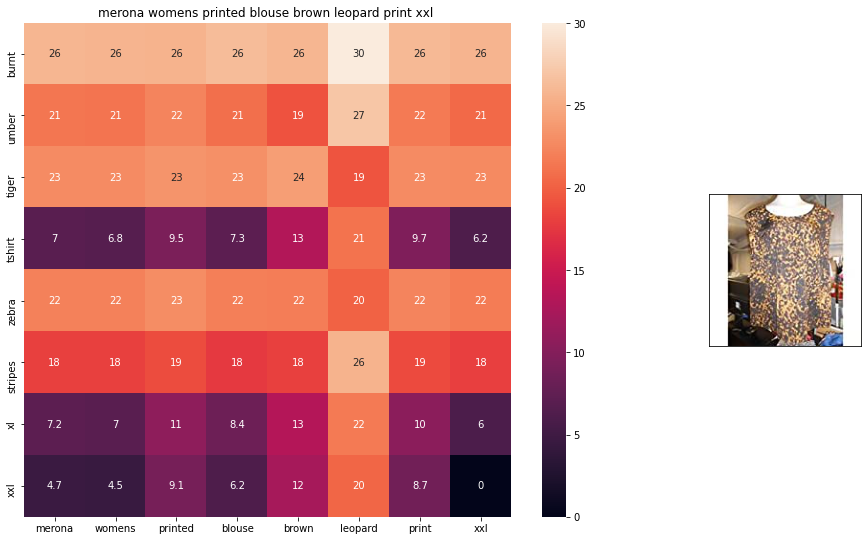

ASIN : B071YF3WDD
Brand : Merona
euclidean distance from input : 6.5982094


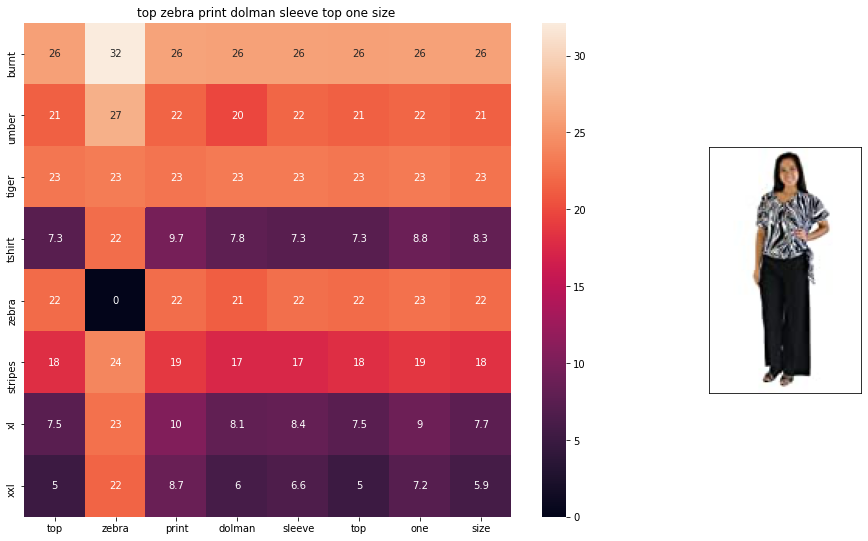

ASIN : B00H8A6ZLI
Brand : Vivian's Fashions
euclidean distance from input : 6.658479


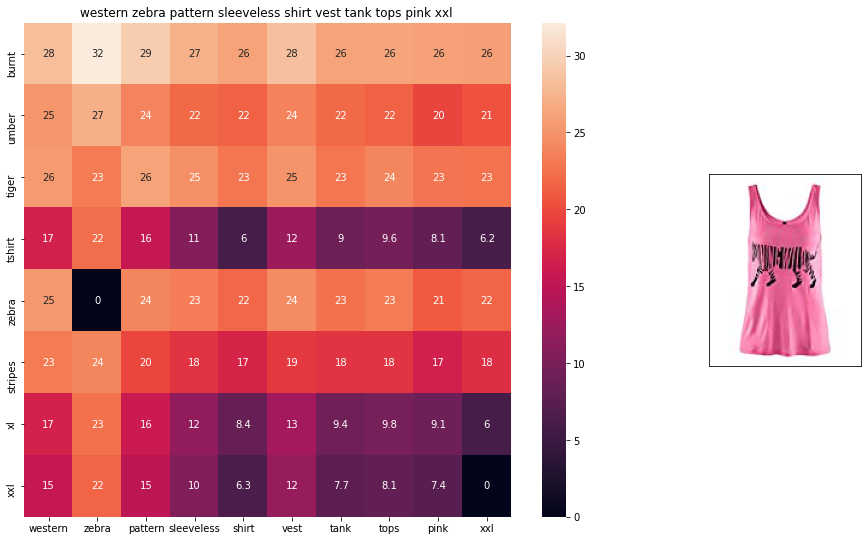

ASIN : B00Z6HEXWI
Brand : Black Temptation
euclidean distance from input : 6.680734


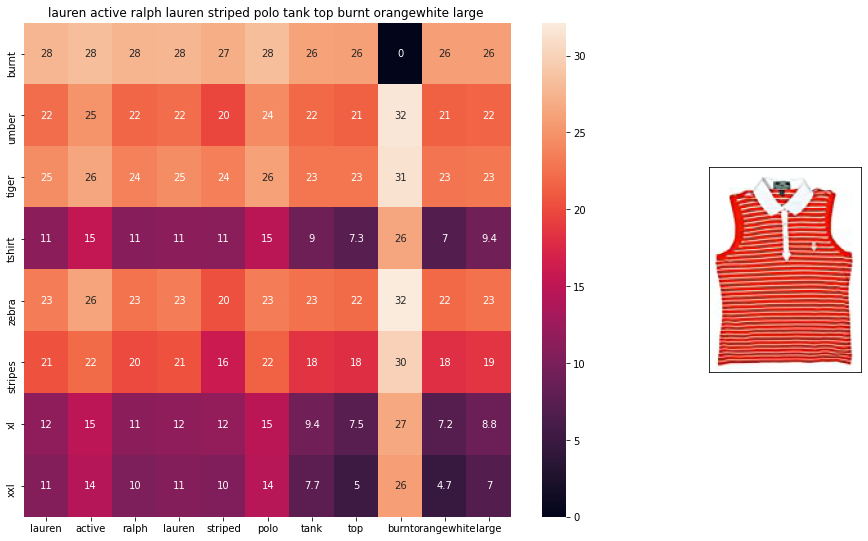

ASIN : B00ILGH5OY
Brand : Ralph Lauren Active
euclidean distance from input : 6.704506


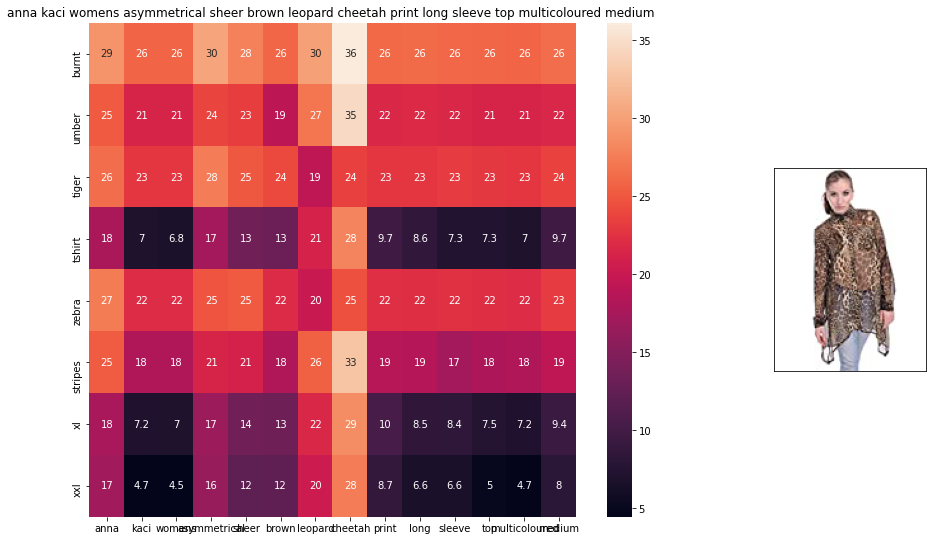

ASIN : B00KSNTY7Y
Brand : Anna-Kaci
euclidean distance from input : 6.7283144


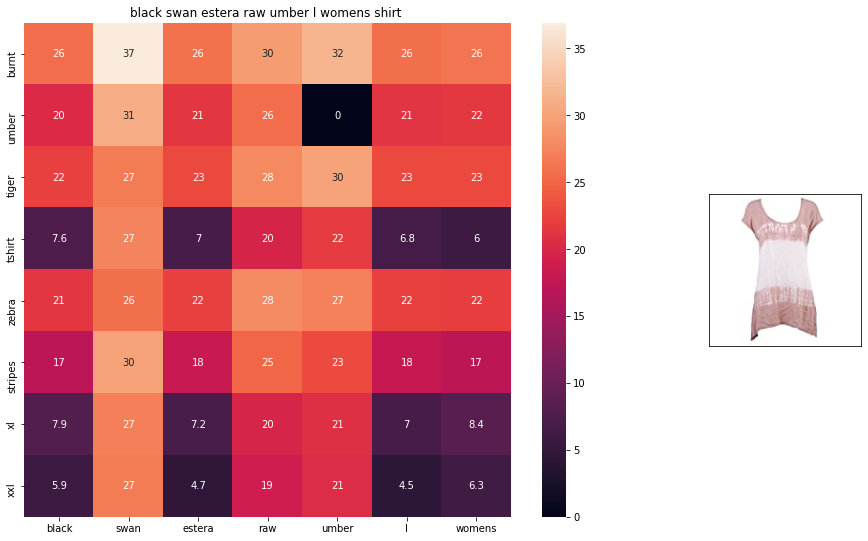

ASIN : B06Y1VN8WQ
Brand : Black Swan
euclidean distance from input : 6.728369


In [134]:
def weighted_w2v_model(doc_id, num_results):
    
    pairwise_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

weighted_w2v_model(12920, 20)